# Lead Scoring Case Study

## Startegy followed for analysis & model building
- EDA: Understand the various columns
- Data pre=processing
    - Missing value imputation - Replace Select with NaN
    - Check data imbalance
    - Handle Outliers
    - Creation Dummy variables 
    - Test train split
    - Standardise numerical values
- Build model and evaluate
    - Build model
    - Feature elimination - automatic and manual
    - Model evaluation
- Predictions
    - Attach a lead score for each row
    - Find a cut off for hot-leads

## Functions
Utility functions for often used functionality

In [10548]:
import importlib

import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# For data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For model building
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For model evaluation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

### Functions - Visualization, Data processing

In [10549]:
def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

def countplot(df, col, ax=None):
    if ax is None:
        sns.countplot(data=df, x=col, hue="Converted")
    else:
        sns.countplot(data=df, x=col, hue="Converted", ax=ax); 
    annotate(ax=ax, title = col)

def colDetails(cols, label):
    print(f"\n{label}: {len(cols)} {cols}")

def colInfo(df, columns):
    for col in columns:
        if df[col].dtype == object:
            if df[col].isnull().sum() > 0:
                values = df[col].unique().tolist()
            else:
                values = sorted(df[col].unique().tolist())
            print(f"{col}: {len(values)} : {values}")
        else:
            #print(f"{col}: {df[col].describe()}")
            # TODO: mean, min, 25, 50, 75, max
            print(f"{col}: {df[col].mean():.0f} {df[col].quantile([0, .25, .50, .75, 1 ]).values.tolist()} ")

    df[columns][:5]

'''
showValues: If number of values are high, then pass False

OUTPUT:

'''
def colInfo1(df, col, showValues=True):
    total = df.shape[0]
    null = df[df[col].isnull()][col].shape[0]

    print(f"{col:10}: {df[col].dtype.name:7} : {null:4}, {100*null/total:5.1f}% : ", end='')

    if showValues == True:
        if df[col].dtype == object:
            unique = df[col].unique().tolist()
            unique = list(set(unique) - {np.nan})
            unique = sorted(unique)
            if df[col].isnull().sum() > 0:
                unique = ['nan'] + unique
            print(f"{len(unique):4}, {100*len(unique)/total:0.1f}% : {unique}", end='')
        else:
            #print(f"{col}: {df[col].describe()}")
            # TODO: mean, min, 25, 50, 75, max
            print(f"{df[col].mean():.0f} {df[col].quantile([0, .25, .50, .75, 1 ]).values.tolist()} ", end='')
    
    print()

def showColumns(df, columns):
    for col in columns:
        colInfo1(df, col)
        
def valueCounts(df, col, ax=None):
    df_ = df[col].fillna('UNKNOWN')
    df_.replace('Select','UNKNOWN', inplace=True)
    values = df_.value_counts()
    values_per = round(100 * df_.value_counts()/df_.shape[0])
    pd.DataFrame({'values':values,'values_per':values_per})
    ax = values_per.plot.bar(ax=ax)
    annotate(ax, title=col)

# TODO: PERCENT
def percent(val, total):
    return round(100 * val/total, 2)

def dropColumns(df, coldesc, cols):
    print(f"Drop {coldesc} {len(cols)} columns: Shape - before {df.shape}", end=" ")
    df.drop(columns = cols, inplace=True)
    print(f"Shape - after {df.shape}")

def addDummies(df, col, dropcat, df_out):
    print("Before", df_out.columns.shape[0], end=' ')
    temp = pd.get_dummies(df[col], prefix=col)
    #df.drop(columns=[col], inplace=True)
    temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print("After", df_out.columns.shape[0])
    return df_out


### Functions - Model Building

In [10550]:
def runRFE(numFeatures, X, y):
    lm = LogisticRegression()
    rfe = RFE(lm, numFeatures)
    rfe = rfe.fit(X,y)
    list(zip(X.columns, rfe.support_, rfe.ranking_))
    cols = X.columns[rfe.support_].tolist()
    print("Columns selected by RFE:", cols)

    dropped_cols.extend(list(set(X.columns)-set(X.columns[rfe.support_].tolist())))
    print("Columns dropped by RFE:", dropped_cols)

    return cols

# Build a  Linear Regression Model
def buildLogRegModel(X, y):
    X_sm = sm.add_constant(X)

    # create the model
    lr = sm.GLM(y, X_sm, family = sm.families.Binomial())
    lr_model = lr.fit()
    #print(lr_model.params)
    print(lr_model.summary())
    return lr_model, X_sm

# Calculate & print VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

dropped_cols = []

# Drop one column from the current dataset and build the model. Store the dropped column in dropped_cols so that these can be dropped from the test dataset also
def dropColumnAndBuildModel(X, y, col=""):
    global dropped_cols
    #print(X_train.columns)
    if col != "":  
        X.drop(columns=col, inplace=True)
        dropped_cols.append(col)
    lr_model, X_sm = buildLogRegModel(X, y)
    getVIF(X)
    return lr_model, X_sm

### Functions - For model evaluation and prediction

In [10551]:
def confusionmatrix(y_train, col_actual, col_predicted):
    confusion = metrics.confusion_matrix(y_train[col_actual], y_train[col_predicted])
    print("Confusion Matrix:\n", confusion)

    # Let's look at other metrices, Sensitivity Specificity
    TP, TN,FP, FN  = confusion[1,1], confusion[0,0], confusion[0,1], confusion[1,0] # false negativies
    sensitivity = TP/float (TP+FN)
    specificity = TN/float (TN+FP)
    fpr = FP/float(TN+FP)
    ppv = TP/float(TP+FP)

    print(f"Accuracy: {round(100 * metrics.accuracy_score(y_train[col_actual],y_train[col_predicted]),2)}% "
          f"Sensitivity: {round(sensitivity*100,2)}% Specificity: {round(specificity*100,2)}% FPR: {round(fpr*100,2)}% PPV: {round(ppv*100,2)}%")

def draw_roc (actual,probs):
    fpr,tpr,thresholds = metrics.roc_curve (actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score (actual,probs)
    plt.figure (figsize =(5,5))
    plt.figure()
    plt.plot(fpr, tpr, label = 'ROC Curve(area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Lead Score')
    plt.legend(loc="lower right")
    plt.show()
    
    return None

def predict(model, X, y):
    y_pred = model.predict(X)
    #print(y_pred [:5])
    #print((y_pred*100).astype(int)[:5])

    y_pred = y_pred.values.reshape(-1)
    #print(y_pred[:5])

    y_pred_final = pd.DataFrame ({'Lead_Actual': y.values, 'Lead_Prob' : y_pred})
    y_pred_final['Lead_ID'] = y.index
    #print(y_pred_final.head())

    y_pred_final['Lead_Predicted'] = y_pred_final['Lead_Prob'].map(lambda x: 1 if x>0.5 else 0)

    ## LOOK at the head of the data
    print(y_pred_final.head())
    return y_pred_final

## Read data set

In [10552]:
df = pd.read_csv("Leads.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

- There are 9240 rows & 37 columns - most of which are cagorical variables and a few are of type numerical.
- Quite a few columns have missing values 
- The names of the columns are lengthy and related columns are not together.

### Rename, Group, Reorder 
For better readability, the columns are 
- lengthy columns names are **renamed**
- **grouped** into sub groups for performing analysis
- **reorderd** so that similar columns occur together

In [10553]:
# Rename the columns that have long names or have spaces
df.rename(columns={'Prospect ID':'ProspectID'}, inplace=True)
df.rename(columns={'What is your current occupation':'Occupation', 'What matters most to you in choosing a course':'Reason'}, inplace=True)
df.rename(columns={'How did you hear about X Education':'Found', 'Search':'AdSearch', 'Magazine':'AdMagazine', 'Newspaper Article':'AdNewspaperArticle',\
                    'Newspaper':'AdNewspaper', 'X Education Forums':'AdForums','Digital Advertisement':'AdDigital', 'Through Recommendations':'Recommendations' }, inplace=True)
df.rename(columns={'Do Not Email':"NoEmail", 'Do Not Call':"NoCall",'Receive More Updates About Our Courses':"CourseUpdates", \
                    'Update me on Supply Chain Content':"SCCUpdates", 'Get updates on DM Content':"DMCUpdates",'A free copy of Mastering The Interview':"FreeCopy",\
                    'I agree to pay the amount through cheque':"PayAmount"}, inplace=True)
df.rename(columns={'Page Views Per Visit':'PageViews', 'Total Time Spent on Website':'TimeSpent','Last Activity':'LastActivity','Last Notable Activity':'LastNotableActivity'}, inplace=True)
df.rename(columns={'Lead Number':'LeadNumber', 'Lead Origin':'LeadOrigin', 'Lead Source': 'LeadSource','Lead Quality':'LeadQuality', 'Lead Profile':'LeadProfile'}, inplace=True)
df.rename(columns={'Asymmetrique Activity Index':'ActivityIndex', 'Asymmetrique Profile Index':'ProfileIndex', 'Asymmetrique Activity Score':'ActivityScore', \
                    'Asymmetrique Profile Score':'ProfileScore'}, inplace=True)

# Group the columns that are similar so that these columns can be analysed together
COLS_ID         = ['ProspectID']            # customer id
COLS_LOC        = ['Country','City']        # Location

COLS_PROF       = ['Occupation','Specialization' , 'Reason'] # Profile
COLS_AD         = ['Found', 'AdSearch', 'AdMagazine', 'AdNewspaperArticle', 'AdForums', 'AdNewspaper', 'AdDigital', 'Recommendations'] # Advertisements
COLS_PREF       = ['NoEmail', 'NoCall','CourseUpdates', 'SCCUpdates', 'DMCUpdates','FreeCopy','PayAmount'] # Preferences

COLS_ACTIVTIY   = ['TotalVisits', 'PageViews', 'TimeSpent','LastActivity', 'LastNotableActivity'] # Activity

COLS_LEAD       = ['LeadNumber', 'LeadOrigin', 'LeadSource','LeadQuality',  'LeadProfile', 'Tags'] # Lead related information
COLS_INDEXSCORE = ['ActivityIndex', 'ProfileIndex', 'ActivityScore', 'ProfileScore'] # Score assigned to each lead

COLS_TARGET     = ['Converted'] # Target variable

# Re-order/sequence the columns based on the workflow
df = df[COLS_ID + COLS_LOC + COLS_PROF + COLS_AD + COLS_PREF + COLS_ACTIVTIY + COLS_LEAD + COLS_INDEXSCORE + COLS_TARGET]

print("After renaming, grouping and reordering", df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ProspectID           9240 non-null   object 
 1   Country              6779 non-null   object 
 2   City                 7820 non-null   object 
 3   Occupation           6550 non-null   object 
 4   Specialization       7802 non-null   object 
 5   Reason               6531 non-null   object 
 6   Found                7033 non-null   object 
 7   AdSearch             9240 non-null   object 
 8   AdMagazine           9240 non-null   object 
 9   AdNewspaperArticle   9240 non-null   object 
 10  AdForums             9240 non-null   object 
 11  AdNewspaper          9240 non-null   object 
 12  AdDigital            9240 non-null   object 
 13  Recommendations      9240 non-null   object 
 14  NoEmail              9240 non-null   object 
 15  NoCall               9240 non-null   o

,ProspectID,Country,City,Occupation,Specialization,Reason,Found,AdSearch,AdMagazine,AdNewspaperArticle,...,LeadOrigin,LeadSource,LeadQuality,LeadProfile,Tags,ActivityIndex,ProfileIndex,ActivityScore,ProfileScore,Converted
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,NaN,Select,Unemployed,Select,Better Career Prospects,Select,No,No,No,...,API,Olark Chat,Low in Relevance,Select,Interested in other courses,02.Medium,02.Medium,15.0,15.0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,India,Select,Unemployed,Select,Better Career Prospects,Select,No,No,No,...,API,Organic Search,NaN,Select,Ringing,02.Medium,02.Medium,15.0,15.0,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,India,Mumbai,Student,Business Administration,Better Career Prospects,Select,No,No,No,...,Landing Page Submission,Direct Traffic,Might be,Potential Lead,Will revert after reading the email,02.Medium,01.High,14.0,20.0,1
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,India,Mumbai,Unemployed,Media and Advertising,Better Career Prospects,Word Of Mouth,No,No,No,...,Landing Page Submission,Direct Traffic,Not Sure,Select,Ringing,02.Medium,01.High,13.0,17.0,0
4,3256f628-e534-4826-9d63-4a8b88782852,India,Mumbai,Unemployed,Select,Better Career Prospects,Other,No,No,No,...,Landing Page Submission,Google,Might be,Select,Will revert after reading the email,02.Medium,01.High,15.0,18.0,1


In [10554]:
# Categorize the columns based on he type and if they contain missing values
COLS = df.columns.tolist(); colDetails(COLS, "COLS")

COLS_CAT = df.select_dtypes(include=['object']).columns; 
COLS_CAT = list(set(COLS_CAT) - set(['Prospect ID']))
colDetails(COLS_CAT, "COLS_CAT")

COLS_NULL = df[df.columns[df.isnull().any()]].columns.tolist(); colDetails(COLS_NULL, "COLS_NULL")


COLS: 37 ['ProspectID', 'Country', 'City', 'Occupation', 'Specialization', 'Reason', 'Found', 'AdSearch', 'AdMagazine', 'AdNewspaperArticle', 'AdForums', 'AdNewspaper', 'AdDigital', 'Recommendations', 'NoEmail', 'NoCall', 'CourseUpdates', 'SCCUpdates', 'DMCUpdates', 'FreeCopy', 'PayAmount', 'TotalVisits', 'PageViews', 'TimeSpent', 'LastActivity', 'LastNotableActivity', 'LeadNumber', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'LeadProfile', 'Tags', 'ActivityIndex', 'ProfileIndex', 'ActivityScore', 'ProfileScore', 'Converted']

COLS_CAT: 30 ['Tags', 'Country', 'AdNewspaper', 'AdNewspaperArticle', 'Specialization', 'LeadOrigin', 'Occupation', 'ProspectID', 'LeadSource', 'AdForums', 'AdDigital', 'CourseUpdates', 'ActivityIndex', 'NoEmail', 'LeadQuality', 'FreeCopy', 'DMCUpdates', 'ProfileIndex', 'LastActivity', 'AdSearch', 'Recommendations', 'LeadProfile', 'LastNotableActivity', 'City', 'SCCUpdates', 'Reason', 'AdMagazine', 'PayAmount', 'NoCall', 'Found']

COLS_NULL: 17 ['Country', 'City'

Out of 37 columns, 30 are of type catgorical, 7 are numerical and 17 columns have missing values

## Exploratory Data Analysis

### Missing Values
Check the missing values for each column. 
For most of the categorical variables, one of the values is 'Select' which means the user has not selected any option. So this should be considered as NaN. So replace the 'Select' with NaN

In [10555]:
# Replace the 'Select' with NaN
df.replace('Select', np.NaN, inplace=True)

In [10556]:
# Check the columns with null values
df[df.columns[df.isnull().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         6779 non-null   object 
 1   City            5571 non-null   object 
 2   Occupation      6550 non-null   object 
 3   Specialization  5860 non-null   object 
 4   Reason          6531 non-null   object 
 5   Found           1990 non-null   object 
 6   TotalVisits     9103 non-null   float64
 7   PageViews       9103 non-null   float64
 8   LastActivity    9137 non-null   object 
 9   LeadSource      9204 non-null   object 
 10  LeadQuality     4473 non-null   object 
 11  LeadProfile     2385 non-null   object 
 12  Tags            5887 non-null   object 
 13  ActivityIndex   5022 non-null   object 
 14  ProfileIndex    5022 non-null   object 
 15  ActivityScore   5022 non-null   float64
 16  ProfileScore    5022 non-null   float64
dtypes: float64(4), object(13)
memory 

There are 17 columns (of categorical and numerical type) with missing values

<AxesSubplot:>

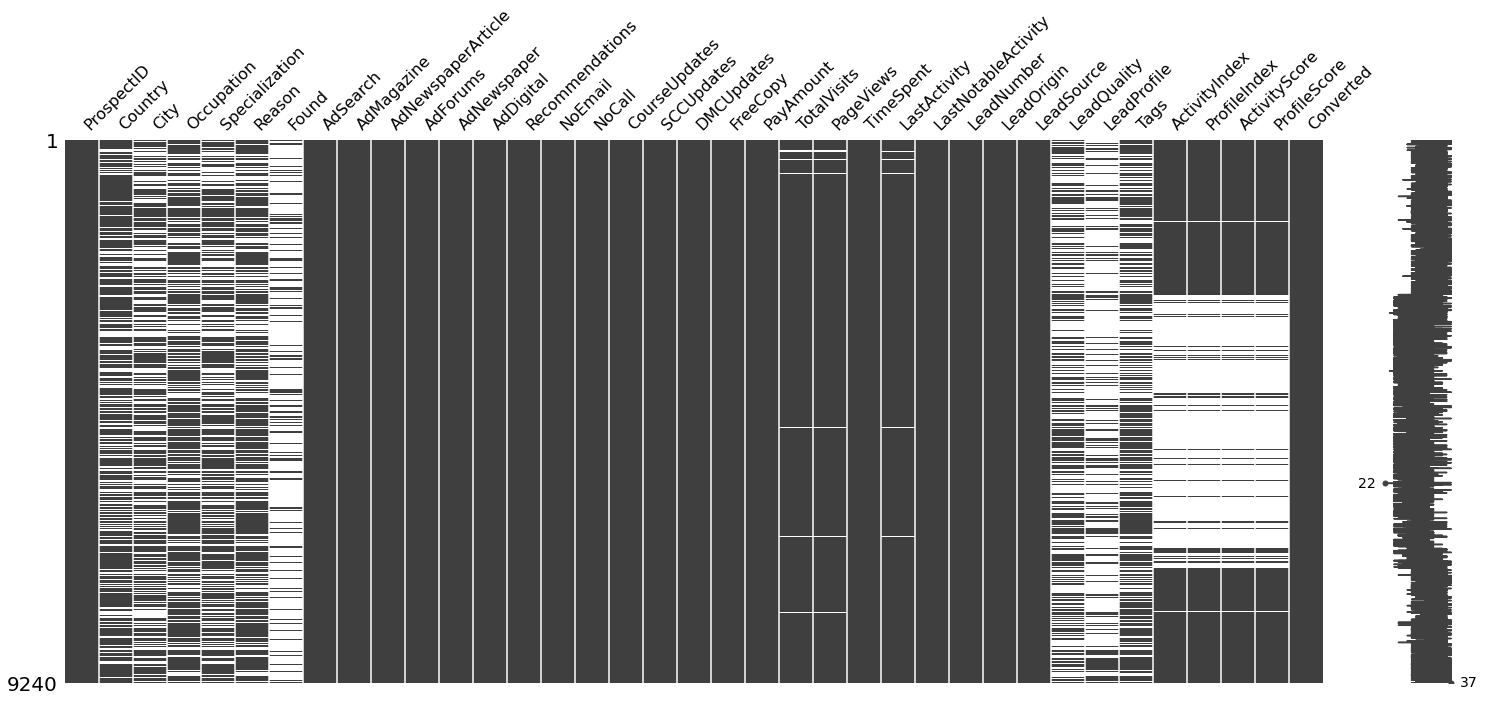

In [10557]:
msno.matrix(df)

<AxesSubplot:>

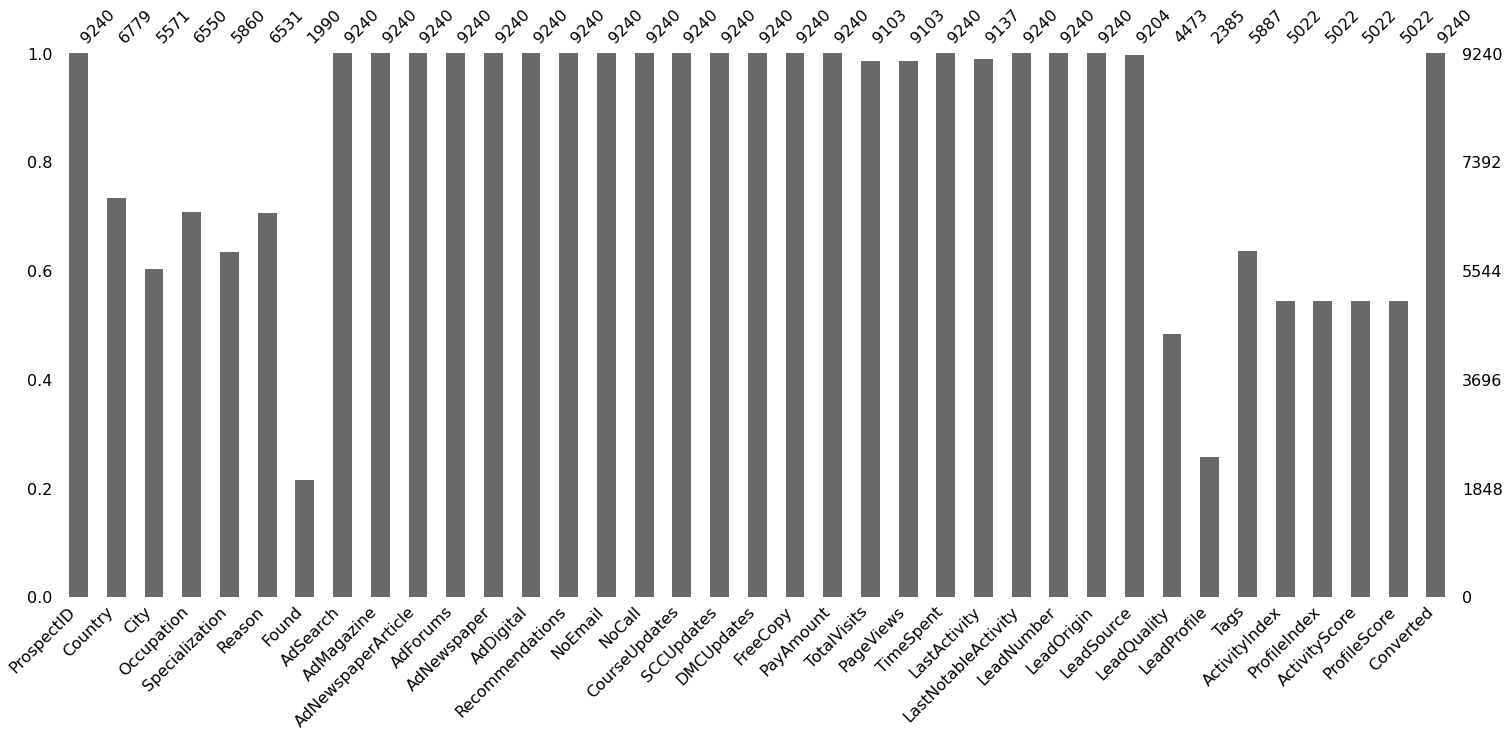

In [10558]:
# Visualize the missing value count - column & row wise
msno.bar(df)

There are 
- Columns have lot of missing values
    - Country, City, Occupation, Specialization, Reason, Found, LeadQuality, LeadProfile, Tags
    - Activity/Profile Index/Score have missing values for the same rows
- Columns with less number of missing values
    - TotalVisits and PageViews have missing values for the same rows
    - LastActivity

In [10560]:
# Check the number (absolute, percentage) of nan's select
TOTAL = df.shape[0]
print(f"COLUMN         : TYPE     : NAN    : NAN%")#   : SELECT: SELECT%")
for col in COLS:
    nan = df[col].isnull().sum()
    #select = df[df[col]=='Select'].shape[0]
    if nan > 0: #or select > 0:
        print(f"{col:15}: {df[col].dtype.name:8} : {nan:6d} : {100 * nan/TOTAL:5.2f}%", end='')# : {select:5d} : {100 * select/TOTAL:5.2f}%", end='')
        print()

COLUMN         : TYPE     : NAN    : NAN%
Country        : object   :   2461 : 26.63%
City           : object   :   3669 : 39.71%
Occupation     : object   :   2690 : 29.11%
Specialization : object   :   3380 : 36.58%
Reason         : object   :   2709 : 29.32%
Found          : object   :   7250 : 78.46%
TotalVisits    : float64  :    137 :  1.48%
PageViews      : float64  :    137 :  1.48%
LastActivity   : object   :    103 :  1.11%
LeadSource     : object   :     36 :  0.39%
LeadQuality    : object   :   4767 : 51.59%
LeadProfile    : object   :   6855 : 74.19%
Tags           : object   :   3353 : 36.29%
ActivityIndex  : object   :   4218 : 45.65%
ProfileIndex   : object   :   4218 : 45.65%
ActivityScore  : float64  :   4218 : 45.65%
ProfileScore   : float64  :   4218 : 45.65%


### COLUMNS - IDs
Identifiers of customer and lead
- Drop them for the model building

In [10561]:
print(df[COLS_ID][:5]); print()

# Check the number of missing values
print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
for col in COLS_ID:
    colInfo1(df, col, showValues=False)

                             ProspectID
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620
1  2a272436-5132-4136-86fa-dcc88c88f482
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc
4  3256f628-e534-4826-9d63-4a8b88782852

COLUMN    : TYPE    : NULL,  NULL% : 
ProspectID: object  :    0,   0.0% : 


In [10562]:
# Drop this column as it is an idenitfier and does not make sense to be part of the model
df.drop(columns=COLS_ID, inplace=True)
df.shape

(9240, 36)

- The prospect Ids are all unique and have no missing values.
- This need not be part of the model

### COLUMNS - LOC
Location of the customer

In [10563]:
# Check the content and missing values
print(df[COLS_LOC][:5]); print()

print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
for col in COLS_LOC:
    colInfo1(df, col, showValues=False)

  Country    City
0     NaN     NaN
1   India     NaN
2   India  Mumbai
3   India  Mumbai
4   India  Mumbai

COLUMN    : TYPE    : NULL,  NULL% : 
Country   : object  : 2461,  26.6% : 
City      : object  : 3669,  39.7% : 


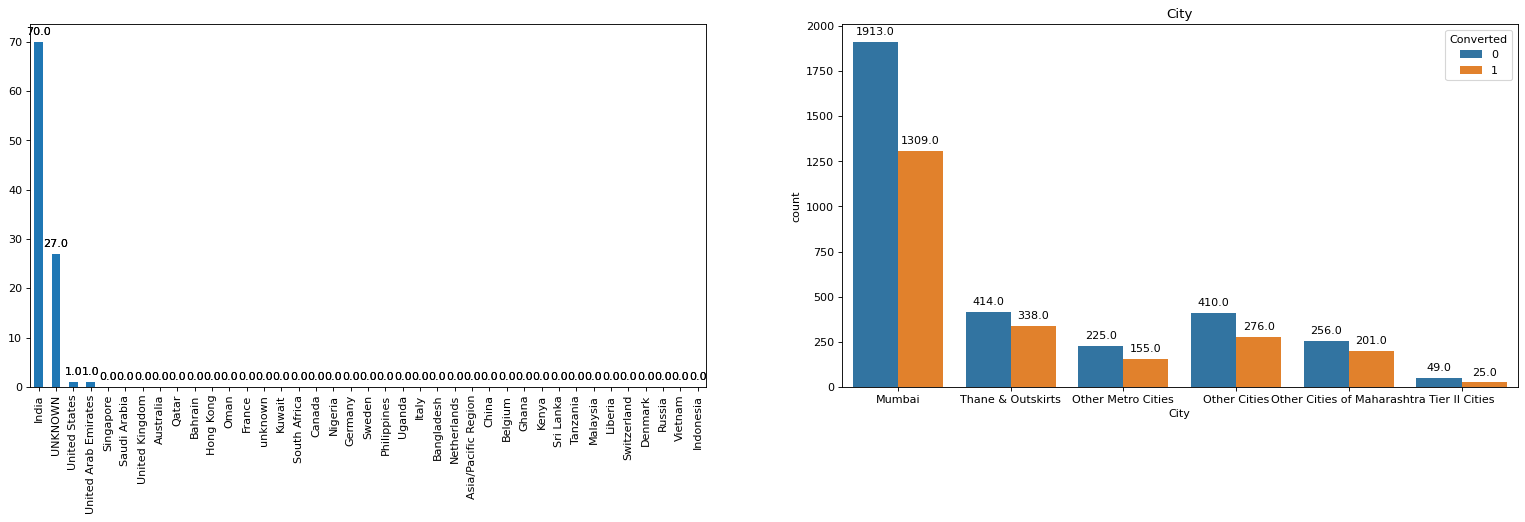

In [10564]:
# See the distribution of the categorical values
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 2, 1); valueCounts(df, 'Country',ax); annotate(ax=ax)
ax = plt.subplot(1, 2, 2); countplot(df, "City", ax)

Entries for countries other than India are very less. So we can combine all these countries into "OTHERS". Also replace missing values with UNKNOWN to visualize in the charts

In [10565]:
# Replace all NaN values wiht UNKNOWN to view them in the visualization
#df['Country'].replace('Select','UNKNOWN', inplace=True)
df['Country'] = df['Country'].fillna('UNKNOWN')
#df['Country'] = df['Country'].apply(lambda x: x if x in ['India', 'UNKNOWN'] else 'OTHERS')

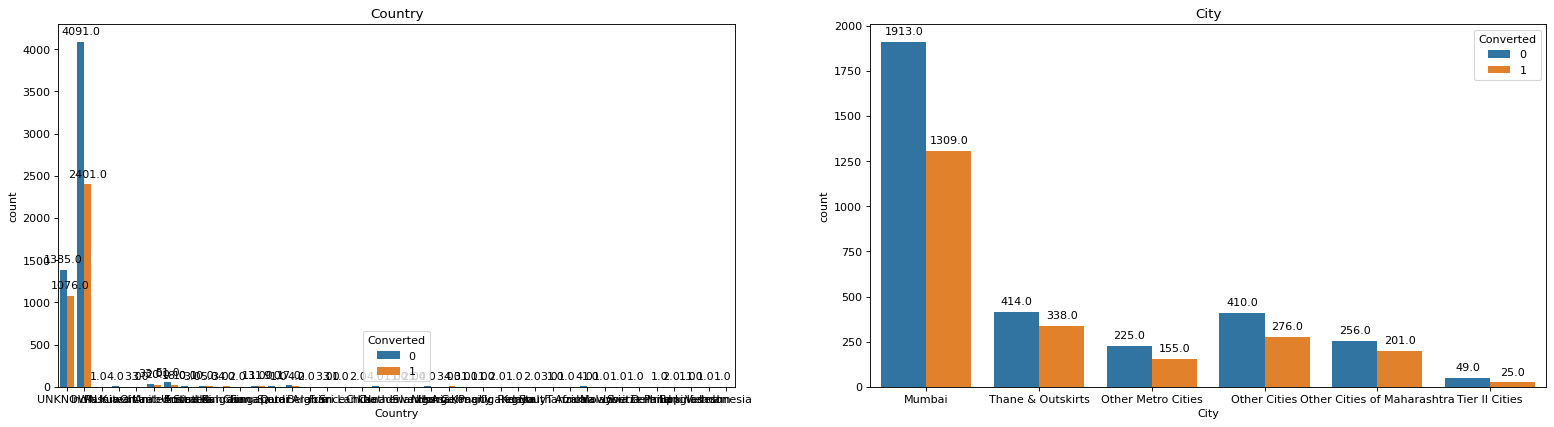

In [10566]:
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 2, 1); countplot(df, "Country",ax);
ax = plt.subplot(1, 2, 2); countplot(df, "City", ax)

We can derive the Country from City column where the values are ('Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai'). 

In [10567]:
count_india_derive = df[(df['Country']=='UNKNOWN') & (~df['City'].isnull()) & (df['City'].isin(['Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai']))]['City'].shape[0]
print("Rows for which country can be derived from city:", count_india_derive)
count_india = df[df['Country']=='India']['Country'].shape[0]
count_nonindia = df[(df['Country']!='India') & (df['Country']!='UNKNOWN')]['Country'].shape[0]
count_india += count_india_derive
count_null = df[df['Country']=='UNKNOWN']['Country'].shape[0]

print(f"India          Non-India    Null")
print(f"{count_india} : {percent(count_india, df.shape[0])}%, {count_nonindia} : {percent(count_nonindia, df.shape[0])}%, {count_null} : {percent(count_null, df.shape[0])}%")

Rows for which country can be derived from city: 334
India          Non-India    Null
6826 : 73.87%, 287 : 3.11%, 2461 : 26.63%


For 2461 rows Country is null and only 3% of the countries are outside india. If we impute India as missing values, then majority data would only be India and this column would add no significance to analysis. So keep the Missing values as a different category "UNKNOWN"

In [10568]:
# See the country to city mapping
df_country = df.groupby(by=['City', 'Country']).agg({'City':'count'})
df_country.rename(columns={'City':'Count'}, inplace=True)
pd.pivot_table(df_country,index='Country', columns=['City'], )

Count                                           \
City                  Mumbai Other Cities Other Cities of Maharashtra   
Country                                                                 
Australia                6.0          2.0                         NaN   
Bahrain                  1.0          2.0                         1.0   
Bangladesh               NaN          2.0                         NaN   
Belgium                  1.0          NaN                         NaN   
Canada                   3.0          NaN                         NaN   
China                    1.0          NaN                         NaN   
Denmark                  NaN          1.0                         NaN   
France                   NaN          2.0                         2.0   
Germany                  1.0          1.0                         1.0   
Ghana                    NaN          1.0                         NaN   
Hong Kong                2.0          2.0                         2.0   
India                 2918.0        564.0                       391.0   
Indonesia                NaN          NaN                         1.0   
Italy                    NaN          1.0                         NaN   
Kenya                    NaN          1.0                         NaN   
Kuwait                   2.0          2.0                         NaN   
Liberia                  NaN          NaN                         NaN   
Malaysia                 NaN          NaN                         1.0   
Netherlands              1.0          NaN                         NaN   
Nigeria                  NaN          3.0                         NaN   
Oman                     2.0          2.0                         NaN   
Philippines              1.0          1.0                         NaN   
Qatar                    3.0          2.0                         1.0   
Saudi Arabia             7.0          9.0                         2.0   
Singapore                6.0          4.0                         2.0   
South Africa             NaN          3.0                         NaN   
Sweden                   1.0          NaN                         NaN   
Switzerland              1.0          NaN                         NaN   
Tanzania                 NaN          NaN                         NaN   
UNKNOWN                211.0         55.0                        43.0   
Uganda                   NaN          1.0                         NaN   
United Arab Emirates    17.0         19.0                         3.0   
United Kingdom           6.0          NaN                         2.0   
United States           30.0          6.0                         5.0   
Vietnam                  1.0          NaN                         NaN   

                                                                          
City                 Other Metro Cities Thane & Outskirts Tier II Cities  
Country                                                                   
Australia                           NaN               3.0            NaN  
Bahrain                             NaN               2.0            1.0  
Bangladesh                          NaN               NaN            NaN  
Belgium                             NaN               1.0            NaN  
Canada                              NaN               NaN            NaN  
China                               NaN               NaN            NaN  
Denmark                             NaN               NaN            NaN  
France                              2.0               NaN            NaN  
Germany                             NaN               1.0            NaN  
Ghana                               NaN               NaN            NaN  
Hong Kong                           NaN               NaN            NaN  
India                             345.0             651.0           69.0  
Indonesia                           NaN               NaN            NaN  
Italy                               NaN         

Many countries (not India) have City as "'Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai' which is incorrect. So we should drop City.

In [10569]:
print("Before: ", df.shape ,end=' '); df.drop(columns='City', inplace=True); print("After: ", df.shape ,end=' ')

Before:  (9240, 36) After:  (9240, 35) 

| Column Name | Missing values? | Handling |
|---|---|---|
| Country | 27% | 27% values of Country is null and only 3% countries are outside india, If we impute India as missing values, then majority data would only be India and this column would add no significance to analysis. So keep the Missing values as a different category "UNKNOWN"|
| City |  | Many countries (not India) have City as "'Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai' which is incorrect. So we dropped City. | 

### COLUMNS - PROF

In [10570]:
# Check the content and missing values
print(df[COLS_PROF][:5]); print()

print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
showColumns(df, COLS_PROF)

   Occupation           Specialization                   Reason
0  Unemployed                      NaN  Better Career Prospects
1  Unemployed                      NaN  Better Career Prospects
2     Student  Business Administration  Better Career Prospects
3  Unemployed    Media and Advertising  Better Career Prospects
4  Unemployed                      NaN  Better Career Prospects

COLUMN    : TYPE    : NULL,  NULL% : 
Occupation: object  : 2690,  29.1% :    7, 0.1% : ['nan', 'Businessman', 'Housewife', 'Other', 'Student', 'Unemployed', 'Working Professional']
Specialization: object  : 3380,  36.6% :   19, 0.2% : ['nan', 'Banking, Investment And Insurance', 'Business Administration', 'E-Business', 'E-COMMERCE', 'Finance Management', 'Healthcare Management', 'Hospitality Management', 'Human Resource Management', 'IT Projects Management', 'International Business', 'Marketing Management', 'Media and Advertising', 'Operations Management', 'Retail Management', 'Rural and Agribusiness', 'Ser

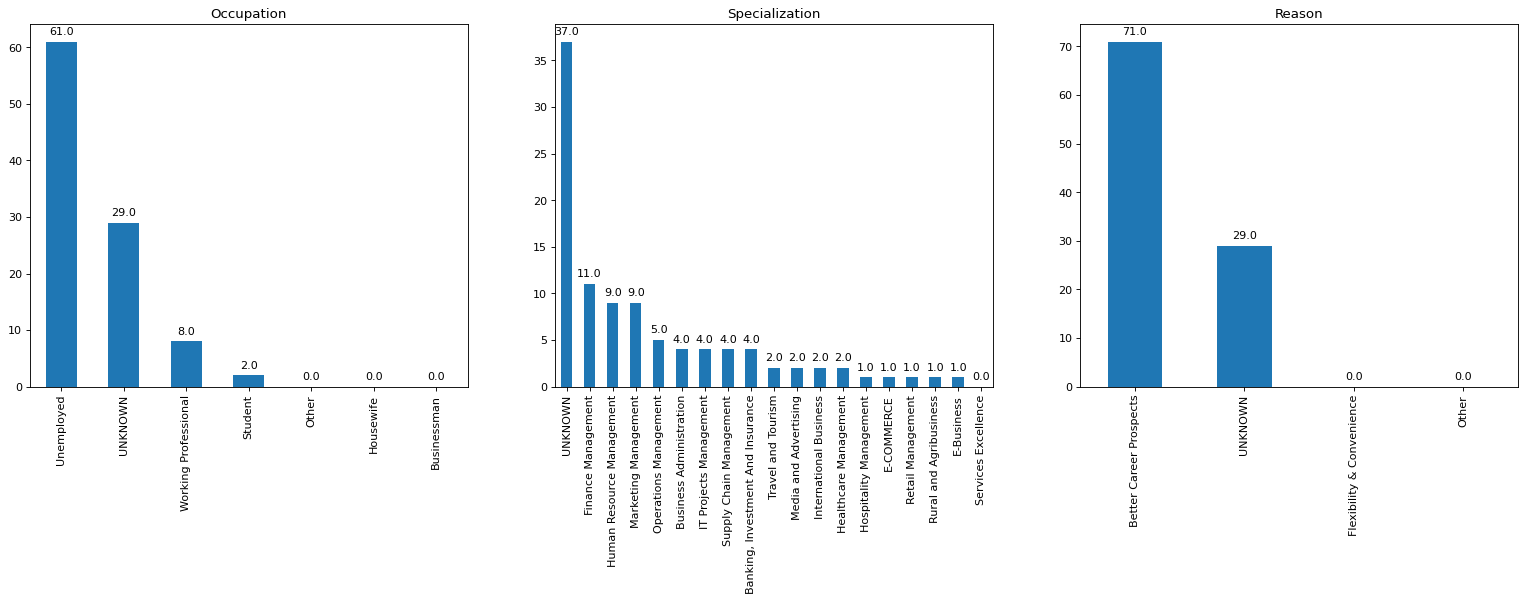

In [10571]:
# Check the distribution of values in the columns
plt.figure(figsize=(24, 6), dpi=80)

ax = plt.subplot(1, 3, 1); valueCounts(df, 'Occupation',ax)
ax = plt.subplot(1, 3, 2); valueCounts(df, 'Specialization', ax)
ax = plt.subplot(1, 3, 3); valueCounts(df, 'Reason', ax)

In [10572]:
# Replace NaN values with UNKNOWN to view in the visaulizations
for col in COLS_PROF:
    df[col] = df[col].fillna('UNKNOWN')

In [10573]:
print(f"COLUMN    : TYPE    : NULL,  NULL% : UNIQUE,  UNIQUE% : VALUES ")
showColumns(df, COLS_PROF)

COLUMN    : TYPE    : NULL,  NULL% : UNIQUE,  UNIQUE% : VALUES 
Occupation: object  :    0,   0.0% :    7, 0.1% : ['Businessman', 'Housewife', 'Other', 'Student', 'UNKNOWN', 'Unemployed', 'Working Professional']
Specialization: object  :    0,   0.0% :   19, 0.2% : ['Banking, Investment And Insurance', 'Business Administration', 'E-Business', 'E-COMMERCE', 'Finance Management', 'Healthcare Management', 'Hospitality Management', 'Human Resource Management', 'IT Projects Management', 'International Business', 'Marketing Management', 'Media and Advertising', 'Operations Management', 'Retail Management', 'Rural and Agribusiness', 'Services Excellence', 'Supply Chain Management', 'Travel and Tourism', 'UNKNOWN']
Reason    : object  :    0,   0.0% :    4, 0.0% : ['Better Career Prospects', 'Flexibility & Convenience', 'Other', 'UNKNOWN']


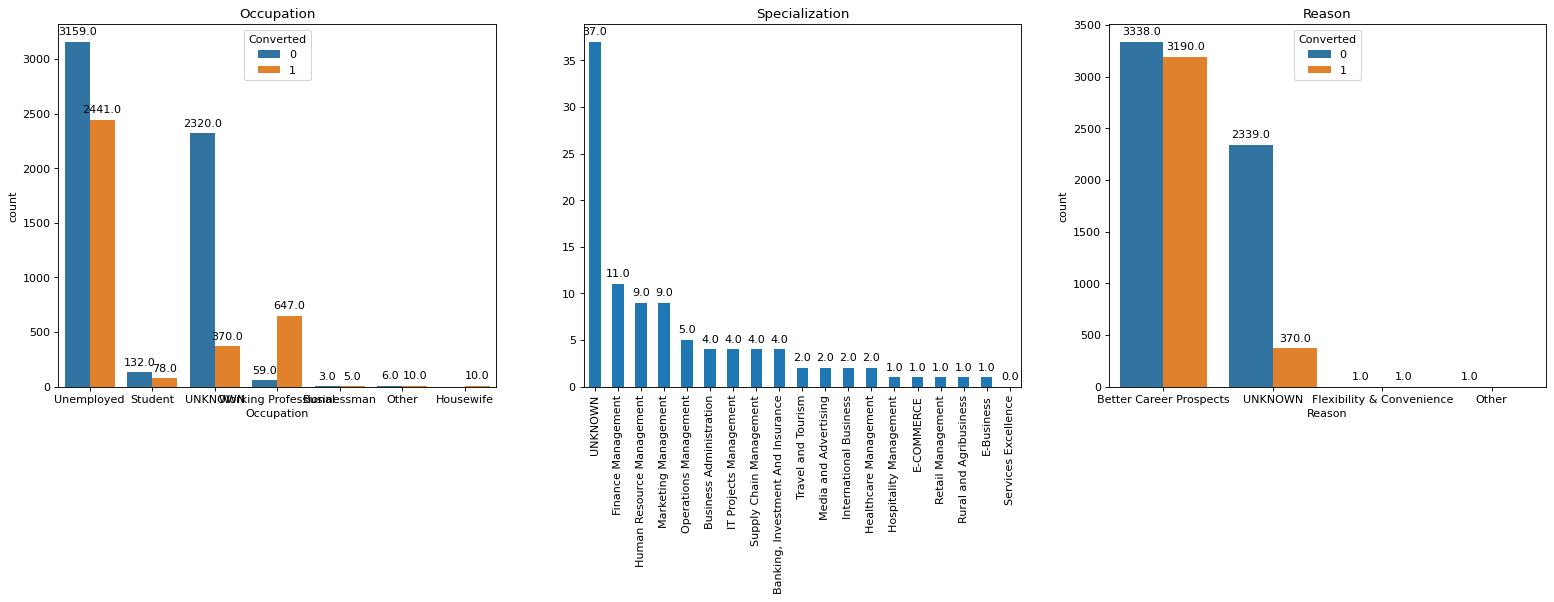

In [10574]:
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 3, 1); countplot(df, "Occupation", ax)
ax = plt.subplot(1, 3, 2); valueCounts(df, 'Specialization', ax)
ax = plt.subplot(1, 3, 3); countplot(df, "Reason", ax)

- Around 29% rows have null Reason. We can impute the Reason with 'Better Career Prospects'. But then only .03% rows have Reason other than 'Better Career Prospects'. So the column Reason will add no significance to the model. So drop the column Reason
- Working Professional and Other has a higher conversion rate

In [10575]:
dropColumns(df, 'Reason', ['Reason'])

Drop Reason 1 columns: Shape - before (9240, 35) Shape - after (9240, 34)


| Column Name | Missing values? | Handling |
|---|---|---|
| Occupation | 29% | Replace missing values as UNKNOWN. |
| Specialization | 15.6% | Replace missing values as UNKNOWN. |
| Reason | 29% | Around 29% rows have null Reason. We can impute the Reason with 'Better Career Prospects'. But then only .03% rows have Reason other than 'Better Career Prospects'. So the column Reason will add no significance to the model. So drop the column Reason |

### COLUMNS - AD

In [10576]:
# Check the content and missing values
print(df[COLS_AD][:5]); print()

print(f"COLUMN    : TYPE    : NULL,  NULL% : UNIQUE,  UNIQUE% : VALUES ")
showColumns(df, COLS_AD)

           Found AdSearch AdMagazine AdNewspaperArticle AdForums AdNewspaper  \
0            NaN       No         No                 No       No          No   
1            NaN       No         No                 No       No          No   
2            NaN       No         No                 No       No          No   
3  Word Of Mouth       No         No                 No       No          No   
4          Other       No         No                 No       No          No   

  AdDigital Recommendations  
0        No              No  
1        No              No  
2        No              No  
3        No              No  
4        No              No  

COLUMN    : TYPE    : NULL,  NULL% : UNIQUE,  UNIQUE% : VALUES 
Found     : object  : 7250,  78.5% :   10, 0.1% : ['nan', 'Advertisements', 'Email', 'Multiple Sources', 'Online Search', 'Other', 'SMS', 'Social Media', 'Student of SomeSchool', 'Word Of Mouth']
AdSearch  : object  :    0,   0.0% :    2, 0.0% : ['No', 'Yes']
AdMagazine: ob

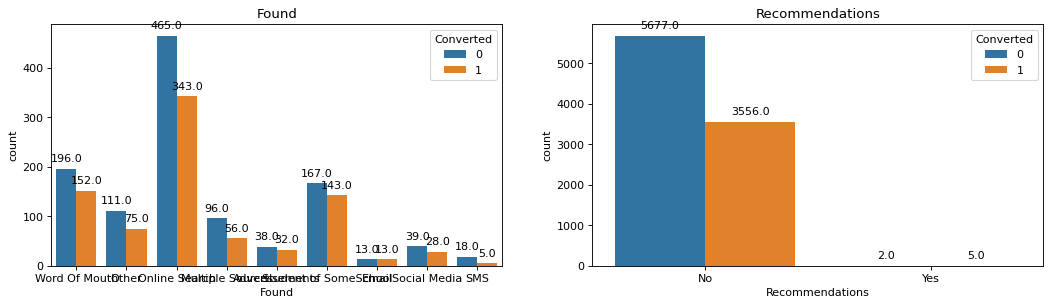

In [10577]:
# Check the distribution of values in the columns
plt.figure(figsize=(16, 4), dpi=80)

ax = plt.subplot(1, 2, 1); countplot(df, "Found", ax)
ax = plt.subplot(1, 2, 2); countplot(df, "Recommendations", ax)

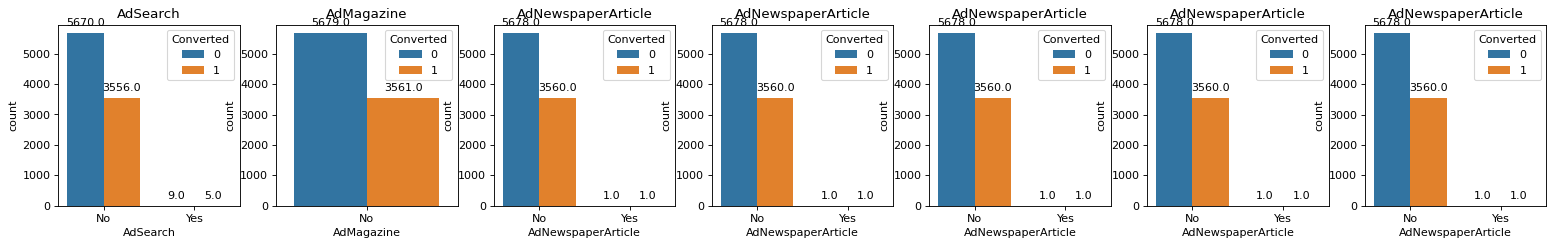

In [10578]:
# Check the distribution of values in the columns
plt.figure(figsize=(24, 3), dpi=80)
ax = plt.subplot(1, 7, 1); countplot(df, "AdSearch", ax)
ax = plt.subplot(1, 7, 2); countplot(df, "AdMagazine", ax)
ax = plt.subplot(1, 7, 3); countplot(df, "AdNewspaperArticle", ax)
ax = plt.subplot(1, 7, 4); countplot(df, "AdNewspaperArticle", ax)
ax = plt.subplot(1, 7, 5); countplot(df, "AdNewspaperArticle", ax)
ax = plt.subplot(1, 7, 6); countplot(df, "AdNewspaperArticle", ax)
ax = plt.subplot(1, 7, 7); countplot(df, "AdNewspaperArticle", ax)

In [10579]:
# Replace NaN values with UNKNOWN
for col in COLS_AD:
    df[col] = df[col].fillna('UNKNOWN')

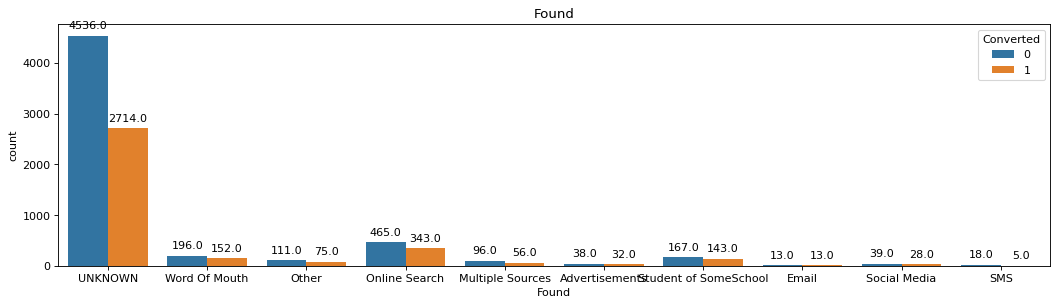

In [10580]:
plt.figure(figsize=(16, 4), dpi=80)
ax = plt.subplot(1, 1, 1); countplot(df, "Found", ax)

In [10581]:
# Remove all Columns except Found as almost all rows have the same value 'No'
dropColumns(df, 'COLS_AD', list(set(COLS_AD)-{'Found'}))

Drop COLS_AD 7 columns: Shape - before (9240, 34) Shape - after (9240, 27)


| Column Name | Missing values - NaN + Select | Handling |
|---|---|---|
| Found | 70% | Group NaN as UNKNOWN  |
| AdXXX | - | Remove Column as almost all rows have the same value 'No' |
| Recommendations | - | Remove Column as almost all rows have the same value 'No' |

### COLUMNS - PREF
Preferences of the lead

In [10582]:
# Check the content and missing values
print(df[COLS_PREF][:5]); print()
print(f"COLUMN    : TYPE    : NULL,  NULL% : UNIQUE,  UNIQUE% : VALUES ")
showColumns(df, COLS_PREF)

  NoEmail NoCall CourseUpdates SCCUpdates DMCUpdates FreeCopy PayAmount
0      No     No            No         No         No       No        No
1      No     No            No         No         No       No        No
2      No     No            No         No         No      Yes        No
3      No     No            No         No         No       No        No
4      No     No            No         No         No       No        No

COLUMN    : TYPE    : NULL,  NULL% : UNIQUE,  UNIQUE% : VALUES 
NoEmail   : object  :    0,   0.0% :    2, 0.0% : ['No', 'Yes']
NoCall    : object  :    0,   0.0% :    2, 0.0% : ['No', 'Yes']
CourseUpdates: object  :    0,   0.0% :    1, 0.0% : ['No']
SCCUpdates: object  :    0,   0.0% :    1, 0.0% : ['No']
DMCUpdates: object  :    0,   0.0% :    1, 0.0% : ['No']
FreeCopy  : object  :    0,   0.0% :    2, 0.0% : ['No', 'Yes']
PayAmount : object  :    0,   0.0% :    1, 0.0% : ['No']


In [10583]:
for col in COLS_PREF:
    print(col, df[col].value_counts().to_list())

NoEmail [8506, 734]
NoCall [9238, 2]
CourseUpdates [9240]
SCCUpdates [9240]
DMCUpdates [9240]
FreeCopy [6352, 2888]
PayAmount [9240]


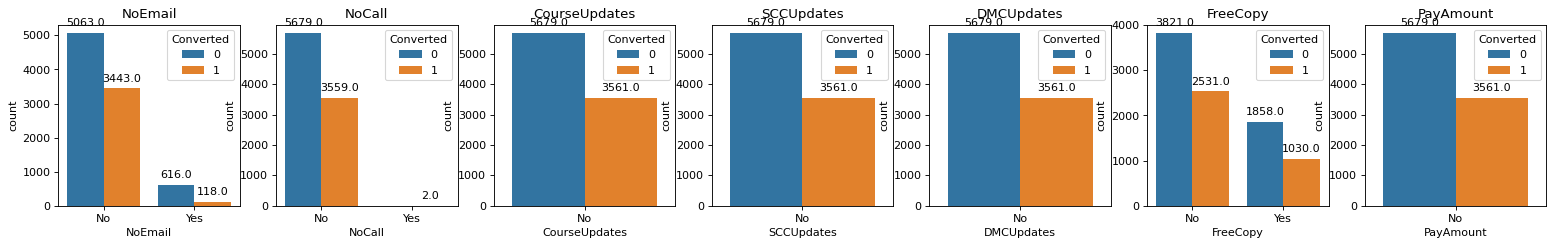

In [10584]:
# Check the distribution of values in the columns
plt.figure(figsize=(24, 3), dpi=80)
ax = plt.subplot(1, 7, 1); countplot(df, "NoEmail", ax)
ax = plt.subplot(1, 7, 2); countplot(df, "NoCall", ax)
ax = plt.subplot(1, 7, 3); countplot(df, "CourseUpdates", ax)
ax = plt.subplot(1, 7, 4); countplot(df, "SCCUpdates", ax)
ax = plt.subplot(1, 7, 5); countplot(df, "DMCUpdates", ax)
ax = plt.subplot(1, 7, 6); countplot(df, "FreeCopy", ax)
ax = plt.subplot(1, 7, 7); countplot(df, "PayAmount", ax)

In [10585]:
# Remove all Columns except Found as almost all rows have the same value 'No' 
dropColumns(df,  "COLS_PREF", list(set(COLS_PREF)-{'NoEmail', 'FreeCopy'}))

Drop COLS_PREF 5 columns: Shape - before (9240, 27) Shape - after (9240, 22)


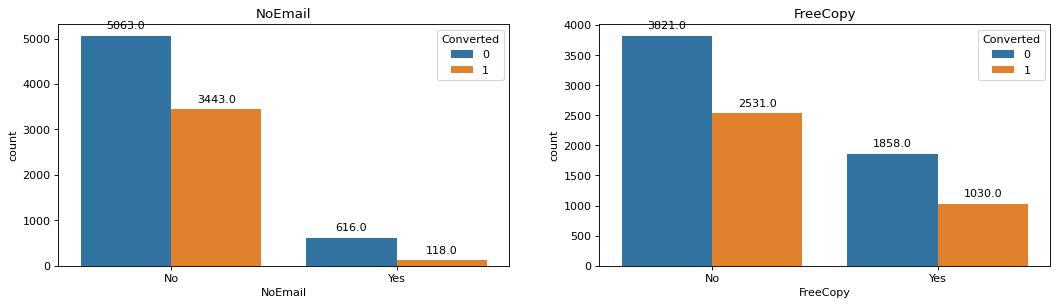

In [10586]:
# Check the distribution of values in the columns
plt.figure(figsize=(16, 4), dpi=80)
ax = plt.subplot(1, 2, 1); countplot(df, "NoEmail", ax)
ax = plt.subplot(1, 2, 2); countplot(df, "FreeCopy", ax)

| Column Name | Missing values? | Handling |
|---|---|---|
| XXX |  - | Remove as almost all rows have the same value 'No' |
| NoEmail |  - | - |
| FreeCopy |  - | - |

### COLUMNS - ACTIVITY
Activity of the lead - Indicator of candidate's interest.
- Visits, Time spent: Higher the value, higher is the interest
- Last Activity & Last Notable Activity have the same values except 'Converted to Lead' of Last Activity. What is the difference? 
- Visits to the site and time spent on the website

In [10587]:
print(df[COLS_ACTIVTIY][:5]); print()

# Check the number of missing values
print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
showColumns(df, COLS_ACTIVTIY)

   TotalVisits  PageViews  TimeSpent             LastActivity  \
0          0.0        0.0          0  Page Visited on Website   
1          5.0        2.5        674             Email Opened   
2          2.0        2.0       1532             Email Opened   
3          1.0        1.0        305              Unreachable   
4          2.0        1.0       1428        Converted to Lead   

  LastNotableActivity  
0            Modified  
1        Email Opened  
2        Email Opened  
3            Modified  
4            Modified  

COLUMN    : TYPE    : NULL,  NULL% : 
TotalVisits: float64 :  137,   1.5% : 3 [0.0, 1.0, 3.0, 5.0, 251.0] 
PageViews : float64 :  137,   1.5% : 2 [0.0, 1.0, 2.0, 3.0, 55.0] 
TimeSpent : int64   :    0,   0.0% : 488 [0.0, 12.0, 248.0, 936.0, 2272.0] 
LastActivity: object  :  103,   1.1% :   18, 0.2% : ['nan', 'Approached upfront', 'Converted to Lead', 'Email Bounced', 'Email Link Clicked', 'Email Marked Spam', 'Email Opened', 'Email Received', 'Form Submitted o

<AxesSubplot:title={'center':'TimeSpent'}, xlabel='Converted'>

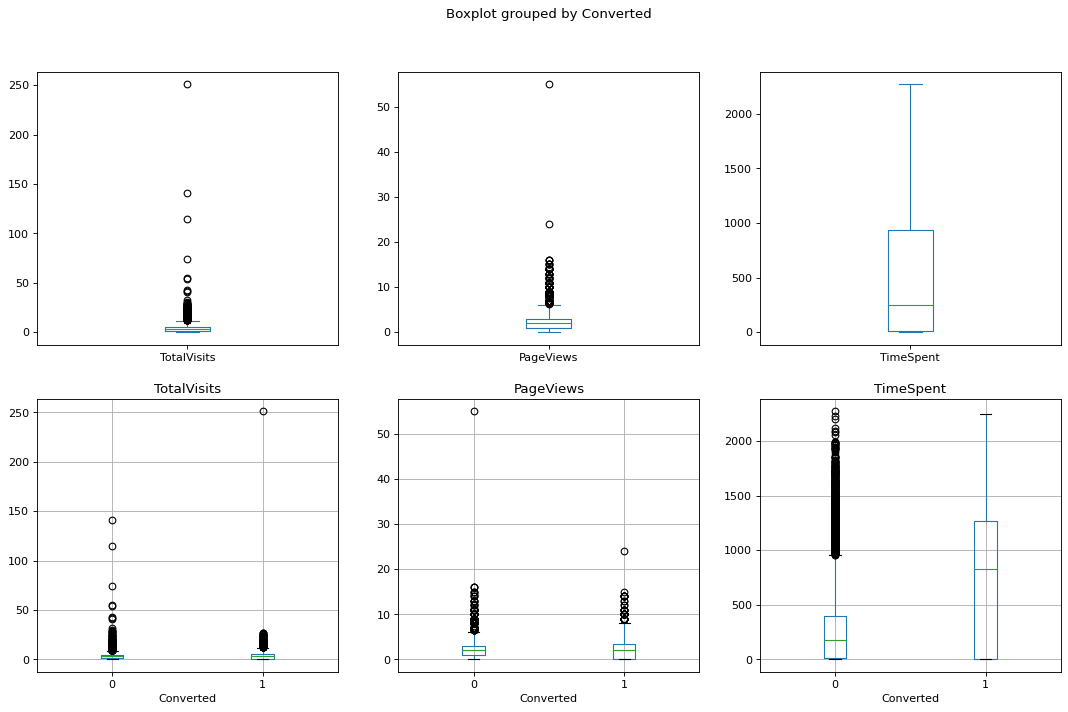

In [10588]:
# Check the distribution of values in the columns
plt.figure(figsize=(16, 10), dpi=80)

ax = plt.subplot(2, 3, 1); df['TotalVisits'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 2); df['PageViews'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 3); df['TimeSpent'].plot.box(ax=ax)

ax = plt.subplot(2, 3, 4); df.boxplot(column=['TotalVisits'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 5); df.boxplot(column=['PageViews'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 6); df.boxplot(column=['TimeSpent'], by='Converted', ax=ax)

In [10589]:
# There are outliers, so we can either remove the rows with missing values or impute the missing values by median
df['TotalVisits'].fillna(df['TotalVisits'].median(), inplace=True)
df['PageViews'].fillna(df['PageViews'].median(), inplace=True)

<AxesSubplot:title={'center':'TimeSpent'}, xlabel='Converted'>

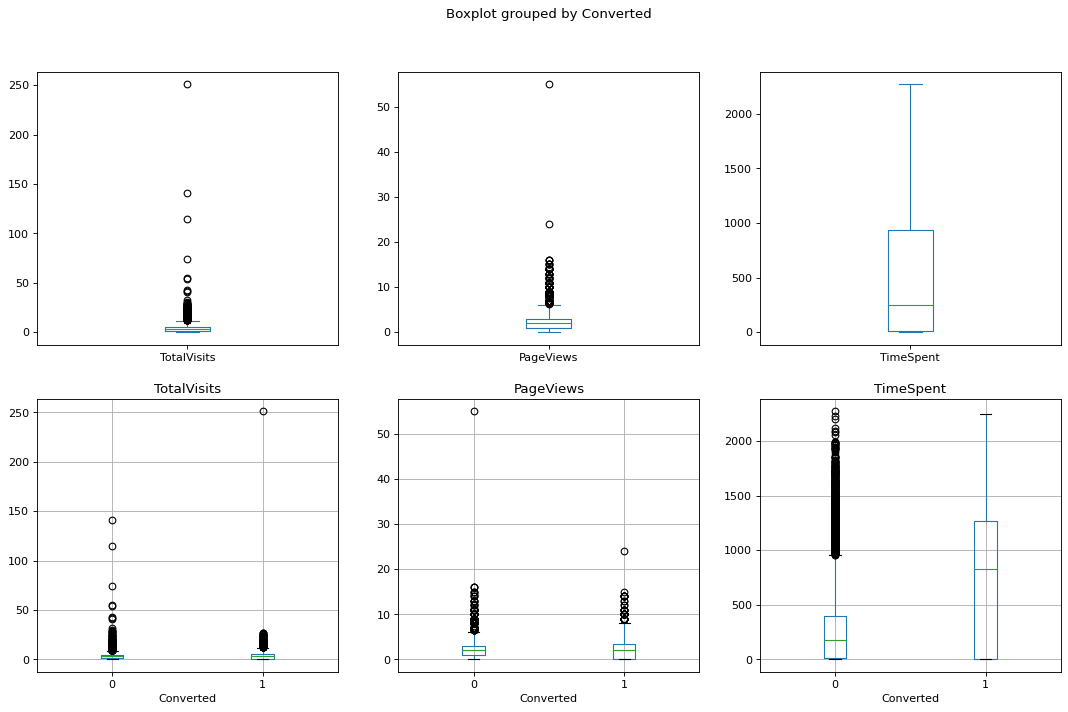

In [10590]:
# Check the distribution of values in the columns - after imputation
plt.figure(figsize=(16, 10), dpi=80)

ax = plt.subplot(2, 3, 1); df['TotalVisits'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 2); df['PageViews'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 3); df['TimeSpent'].plot.box(ax=ax)

ax = plt.subplot(2, 3, 4); df.boxplot(column=['TotalVisits'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 5); df.boxplot(column=['PageViews'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 6); df.boxplot(column=['TimeSpent'], by='Converted', ax=ax)

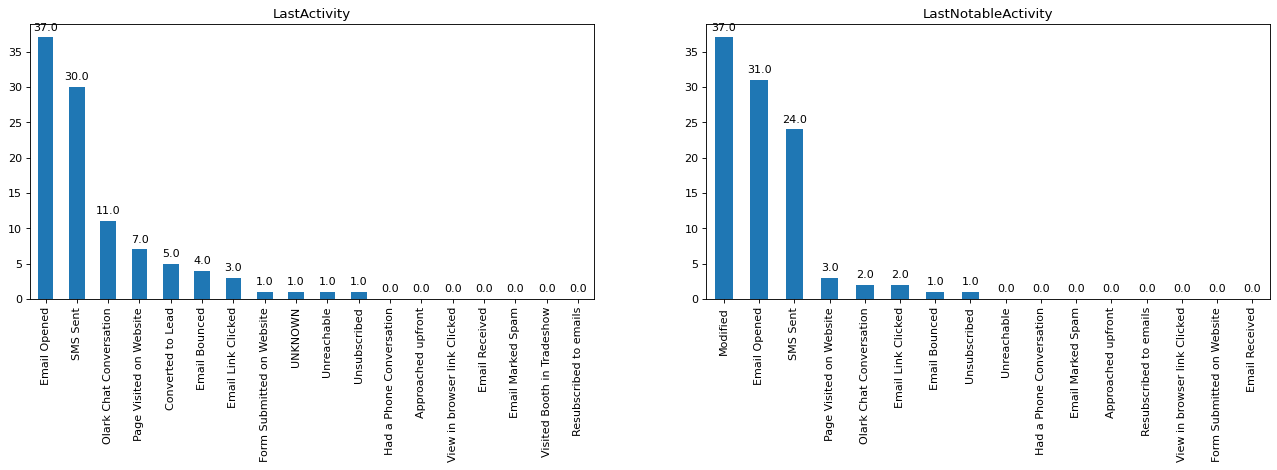

In [10591]:
# Check the distribution of values in the columns
plt.figure(figsize=(20, 10), dpi=80)
ax = plt.subplot(2, 2, 1); valueCounts(df, 'LastActivity',ax) 
ax = plt.subplot(2, 2, 2); valueCounts(df, 'LastNotableActivity',ax) 

In [10592]:
df[(df['LastActivity'].isnull()) & (df['Converted']==1)][['LastActivity', 'LastNotableActivity','Converted']]

,LastActivity,LastNotableActivity,Converted
77,NaN,Modified,1
79,NaN,Modified,1
81,NaN,Modified,1
88,NaN,Modified,1
120,NaN,Modified,1
...,...,...,...
8081,NaN,Modified,1
8107,NaN,Modified,1
8434,NaN,Modified,1
9015,NaN,Modified,1


In [10593]:
# Values for both these columns aer similar. What are the values that are in one column but not in the other?
print("Values in LastActity but not in LastNotableActivity: ", set(df['LastActivity'].unique())-set(df['LastNotableActivity'].unique()))
print("Values in LastNotableActivity but not in LastActity: ", set(df['LastNotableActivity'].unique())-set(df['LastActivity'].unique()))

Values in LastActity but not in LastNotableActivity:  {nan, 'Converted to Lead', 'Visited Booth in Tradeshow'}
Values in LastNotableActivity but not in LastActity:  {'Modified'}


In [10594]:
df[df['LastActivity']=='Converted to Lead'][['LastActivity','Converted']].groupby(by=['Converted']).agg({'Converted':'count'})

,Converted
Converted,
0,374
1,54


In [10595]:
df[['LastActivity','LastNotableActivity', 'Converted']]

,LastActivity,LastNotableActivity,Converted
0,Page Visited on Website,Modified,0
1,Email Opened,Email Opened,0
2,Email Opened,Email Opened,1
3,Unreachable,Modified,0
4,Converted to Lead,Modified,1
...,...,...,...
9235,Email Marked Spam,Email Marked Spam,1
9236,SMS Sent,SMS Sent,0
9237,SMS Sent,SMS Sent,0
9238,SMS Sent,SMS Sent,1


In [10596]:
# In the case where LastActivity and LastNotableActivity are equal
df[df['LastActivity']==df['LastNotableActivity']][['LastActivity','LastNotableActivity', 'Converted']]

,LastActivity,LastNotableActivity,Converted
1,Email Opened,Email Opened,0
2,Email Opened,Email Opened,1
8,Email Opened,Email Opened,0
9,Email Opened,Email Opened,0
10,Email Opened,Email Opened,1
...,...,...,...
9233,SMS Sent,SMS Sent,1
9235,Email Marked Spam,Email Marked Spam,1
9236,SMS Sent,SMS Sent,0
9237,SMS Sent,SMS Sent,0


In [10597]:
# In the cases where LastActivity and LastNotableActivity are not equal, what are the values
print(df[df['LastActivity']!=df['LastNotableActivity']][['LastActivity','LastNotableActivity', 'Converted']].shape[0], "\n\n",
        df[(df['LastActivity']!=df['LastNotableActivity'])][['LastActivity']].value_counts(), "\n\n",
        df[(df['LastActivity']!=df['LastNotableActivity'])][['LastNotableActivity']].value_counts() )

3407 

 LastActivity                
Olark Chat Conversation         790
Email Opened                    610
SMS Sent                        573
Converted to Lead               428
Page Visited on Website         322
Email Bounced                   266
Form Submitted on Website       115
Email Link Clicked               94
Unreachable                      61
Had a Phone Conversation         16
Unsubscribed                     14
Approached upfront                8
View in browser link Clicked      5
Email Received                    1
Visited Booth in Tradeshow        1
dtype: int64 

 LastNotableActivity
Modified               3407
dtype: int64


In [10598]:
# In the case where LastActivity is null, what are the values of LastNotableActivity?
df[(df['LastActivity'].isnull())][['LastNotableActivity']].value_counts()

LastNotableActivity
Modified               103
dtype: int64

- In the cases where LastActivity and LastNotableActivity are not equal, the LastNotableActivity is always "Modified'. We can retain 'LastActivity' and drop 'LastNotableActivity'
- In the cases where LastActivity is null, the LastNotableActivity is always "Modified'. We can retain 'LastActivity' and drop 'LastNotableActivity'

In [10599]:
dropColumns(df,  "COLS_ACTIVITY", ['LastNotableActivity'])

Drop COLS_ACTIVITY 1 columns: Shape - before (9240, 22) Shape - after (9240, 21)


In [10600]:
# The number of rows that are null is very less. So remove the rows with NULL values.
print(f"LastActivity - Before {df.shape}", end=' '); df = df[~df['LastActivity'].isnull()]; print(f"After {df.shape}")

LastActivity - Before (9240, 21) After (9137, 21)


In [10601]:
df['LastActivity'].value_counts().index

Index(['Email Opened', 'SMS Sent', 'Olark Chat Conversation',
       'Page Visited on Website', 'Converted to Lead', 'Email Bounced',
       'Email Link Clicked', 'Form Submitted on Website', 'Unreachable',
       'Unsubscribed', 'Had a Phone Conversation', 'Approached upfront',
       'View in browser link Clicked', 'Email Received', 'Email Marked Spam',
       'Visited Booth in Tradeshow', 'Resubscribed to emails'],
      dtype='object')

In [10602]:
# Group to less freuqnetly occurring values as OTHERS
# df['LastActivity'] = df['LastActivity'].apply(lambda x: x if x in ['Email Opened', 'SMS Sent', 'Olark Chat Conversation',
#       'Page Visited on Website', 'Converted to Lead'] else 'OTHERS')

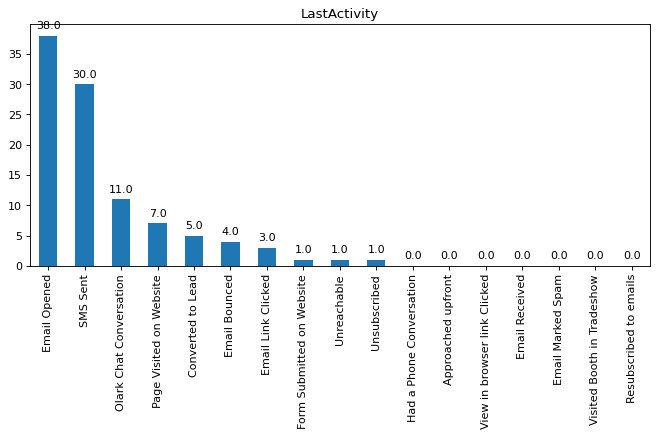

In [10603]:
plt.figure(figsize=(10, 4), dpi=80)
valueCounts(df, 'LastActivity') 

| Column Name | Missing values? | Select? | Handling |
|---|---|---|---|
| TotalVisits | 1.5% | - | Impute with median |
| PageViews | 1.5% | - | Impute with median |
| TimeSpent | -  | - | - |
| LastActivity |  1.1% | -  | Remove the rows with null values |
| LastNotableActivity | - | - | - |

### COLUMNS - LEAD
Lead related data - Where was the customer identified as a lead? Source, quality and level/profile of the lead


In [10604]:
print(df[COLS_LEAD][:5]); print()

# Check the number of missing values
print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
showColumns(df, COLS_LEAD)

   LeadNumber               LeadOrigin      LeadSource       LeadQuality  \
0      660737                      API      Olark Chat  Low in Relevance   
1      660728                      API  Organic Search               NaN   
2      660727  Landing Page Submission  Direct Traffic          Might be   
3      660719  Landing Page Submission  Direct Traffic          Not Sure   
4      660681  Landing Page Submission          Google          Might be   

      LeadProfile                                 Tags  
0             NaN          Interested in other courses  
1             NaN                              Ringing  
2  Potential Lead  Will revert after reading the email  
3             NaN                              Ringing  
4             NaN  Will revert after reading the email  

COLUMN    : TYPE    : NULL,  NULL% : 
LeadNumber: int64   :    0,   0.0% : 617060 [579533.0, 596412.0, 615320.0, 637189.0, 660737.0] 
LeadOrigin: object  :    0,   0.0% :    5, 0.1% : ['API', 'Landing

In [10605]:
# LeadSource has Google and google. These can be combined into 1
df['LeadSource'] = df['LeadSource'].apply(lambda x: 'Google' if x == 'google' else x)

# Check the number of missing values
print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
showColumns(df, COLS_LEAD)

COLUMN    : TYPE    : NULL,  NULL% : 
LeadNumber: int64   :    0,   0.0% : 617060 [579533.0, 596412.0, 615320.0, 637189.0, 660737.0] 
LeadOrigin: object  :    0,   0.0% :    5, 0.1% : ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']
LeadSource: object  :   34,   0.4% :   21, 0.2% : ['nan', 'Click2call', 'Direct Traffic', 'Facebook', 'Google', 'Live Chat', 'NC_EDM', 'Olark Chat', 'Organic Search', 'Pay per Click Ads', 'Press_Release', 'Reference', 'Referral Sites', 'Social Media', 'WeLearn', 'Welingak Website', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel']
LeadQuality: object  : 4742,  51.9% :    6, 0.1% : ['nan', 'High in Relevance', 'Low in Relevance', 'Might be', 'Not Sure', 'Worst']
LeadProfile: object  : 6801,  74.4% :    6, 0.1% : ['nan', 'Dual Specialization Student', 'Lateral Student', 'Other Leads', 'Potential Lead', 'Student of SomeSchool']
Tags      : object  : 3344,  36.6% :   27, 0.3% : ['nan', 'Already a student', 'Bus

In [10606]:
print('LeadSource', df[df['LeadSource'].isnull()]['Converted'].value_counts())
print('LeadQuality', df[df['LeadQuality'].isnull()]['Converted'].value_counts())
print('LeadProfile', df[df['LeadProfile'].isnull()]['Converted'].value_counts())
print('Tags', df[df['Tags'].isnull()]['Converted'].value_counts())

LeadSource 1    28
0     6
Name: Converted, dtype: int64
LeadQuality 0    3736
1    1006
Name: Converted, dtype: int64
LeadProfile 0    4776
1    2025
Name: Converted, dtype: int64
Tags 0    2516
1     828
Name: Converted, dtype: int64


- LeadSource:  Has very less missing values. The rows can be removed.
- LeadQuality: Has lot of missing values. The column can be removed.

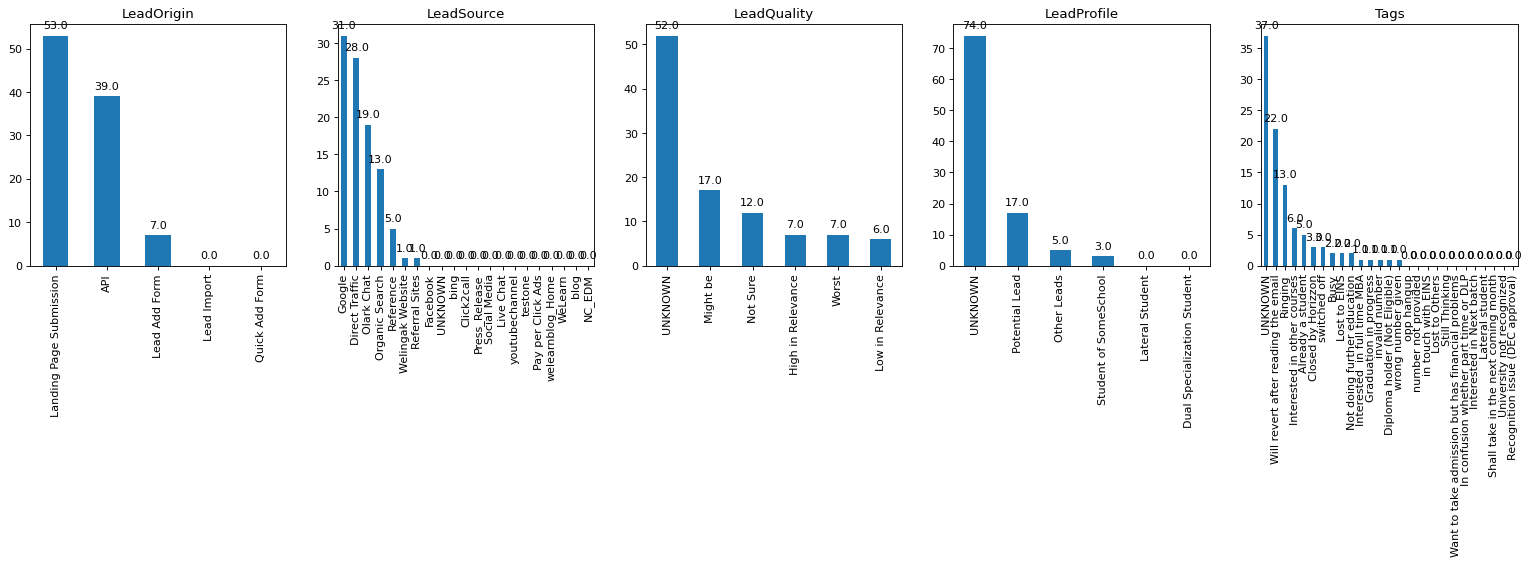

In [10607]:
# Check the distribution of values in the columns
plt.figure(figsize=(24, 4), dpi=80)
ax = plt.subplot(1, 5, 1); valueCounts(df, 'LeadOrigin',ax)
ax = plt.subplot(1, 5, 2); valueCounts(df, 'LeadSource',ax)
ax = plt.subplot(1, 5, 3); valueCounts(df, 'LeadQuality', ax)
ax = plt.subplot(1, 5, 4); valueCounts(df, 'LeadProfile', ax)
ax = plt.subplot(1, 5, 5); valueCounts(df, 'Tags', ax)

In [10608]:
# Replace NaN value with UNKNONW
df['LeadSource']= df['LeadSource'].fillna('UNKNOWN')
df['LeadProfile']= df['LeadProfile'].fillna('UNKNOWN')
df['Tags']= df['Tags'].fillna('UNKNOWN')

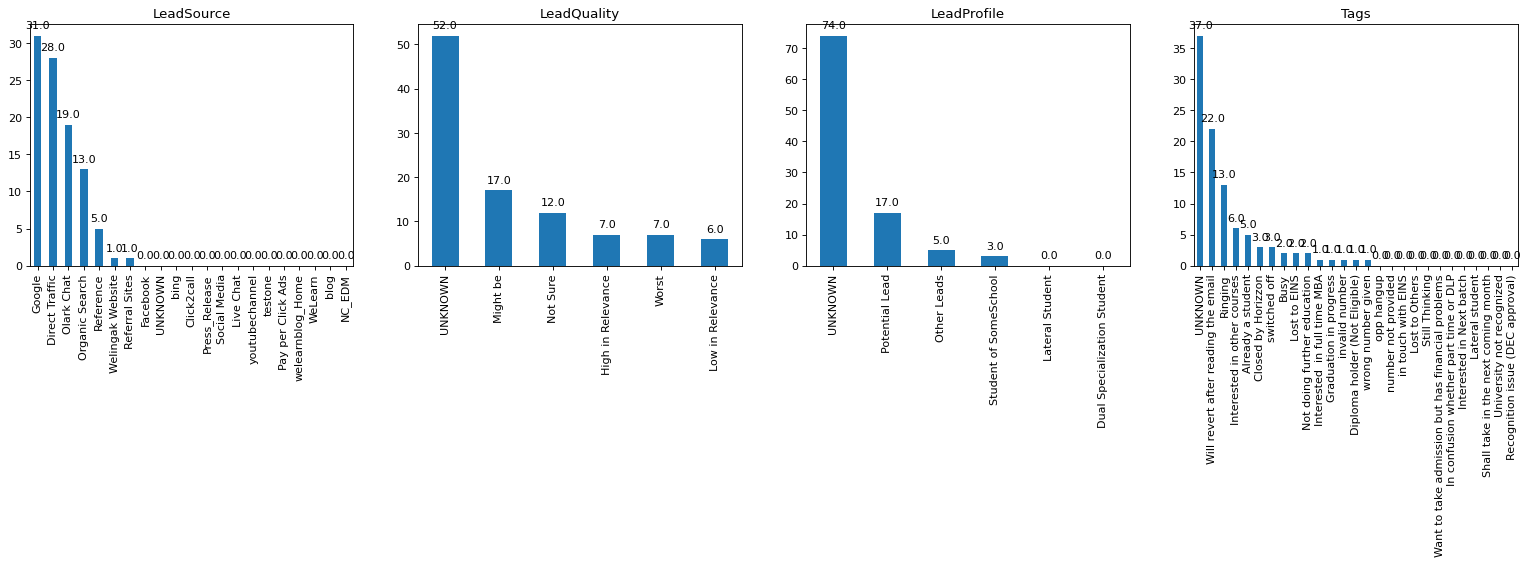

In [10609]:
plt.figure(figsize=(24, 4), dpi=80)
ax = plt.subplot(1, 4, 1); valueCounts(df, 'LeadSource',ax)
ax = plt.subplot(1, 4, 2); valueCounts(df, 'LeadQuality', ax)
ax = plt.subplot(1, 4, 3); valueCounts(df, 'LeadProfile', ax)
ax = plt.subplot(1, 4, 4); valueCounts(df, 'Tags', ax)

In [10610]:
# LeadeNumber os an identifier. So not required in the model.
# LeadProfile has 74% of the values missing. Drop the column
# Drop tags also. As including it gives a bad test accuracy and sensitivity
dropColumns(df, 'COLS_LEAD', ['LeadNumber', 'LeadProfile', 'Tags'])

Drop COLS_LEAD 3 columns: Shape - before (9137, 21) Shape - after (9137, 18)


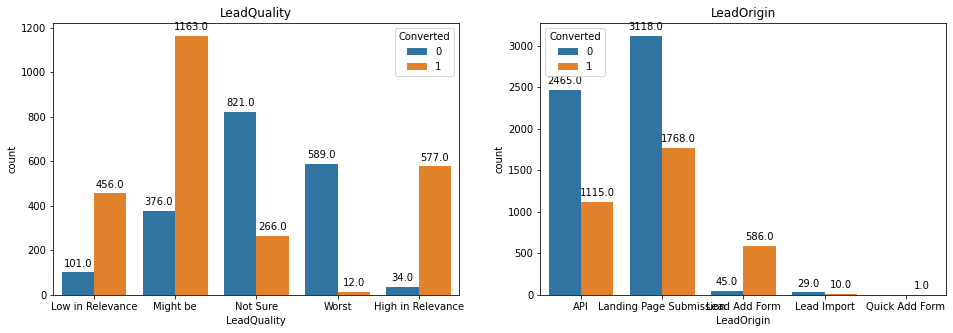

In [10611]:
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1); countplot(df, 'LeadQuality', ax)
ax = plt.subplot(1, 2, 2); countplot(df, 'LeadOrigin', ax)

- The conversion rate is higher in
    - Lead Quality = "High in Relevance", "Low in Relevance" and "Might be"
    - Lead Origin = "Lead Add Form"
- The conversion rate is lowest in Lead Quality = "Worst"

| Column Name | Missing values? | Handling |
|---|---|---|
| LeadNumber | - | Drop as this is an ID |
| LeadOrigin | - | - |
| LeadSource | 0.4% | - |
| LeadQuality | 51.6% | Replace missing values with UNKNOWN |
| LeadProfile | 29.3% | LeadProfile has 74% of the values missing. Drop the column |
| Tags | 36.3% | Drop tags column as including it gives a bad test accuracy and sensitivity|

### COLUMNS - INDEXSCORE

In [10612]:
print(df[COLS_INDEXSCORE][:5]); print()

# Check the number of missing values
print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
showColumns(df, COLS_INDEXSCORE)

  ActivityIndex ProfileIndex  ActivityScore  ProfileScore
0     02.Medium    02.Medium           15.0          15.0
1     02.Medium    02.Medium           15.0          15.0
2     02.Medium      01.High           14.0          20.0
3     02.Medium      01.High           13.0          17.0
4     02.Medium      01.High           15.0          18.0

COLUMN    : TYPE    : NULL,  NULL% : 
ActivityIndex: object  : 4175,  45.7% :    4, 0.0% : ['nan', '01.High', '02.Medium', '03.Low']
ProfileIndex: object  : 4175,  45.7% :    4, 0.0% : ['nan', '01.High', '02.Medium', '03.Low']
ActivityScore: float64 : 4175,  45.7% : 14 [7.0, 14.0, 14.0, 15.0, 18.0] 
ProfileScore: float64 : 4175,  45.7% : 16 [11.0, 15.0, 16.0, 18.0, 20.0] 


The number of missing values is quite high. Drop these columns

In [10613]:
dropColumns(df, 'COLS_INDEXSCORE', COLS_INDEXSCORE)

Drop COLS_INDEXSCORE 4 columns: Shape - before (9137, 18) Shape - after (9137, 14)


| Column Name | Missing values? | Select? | Handling |
|---|---|---|---|
| ActivityIndex | 45.6%  | - | Almost half of the values are missing. Remove the column |
| ProfileIndex | 45.6%  | - | Almost half of the values are missing. Remove the column |
| ActivityScore | 45.6%  | - | Almost half of the values are missing. Remove the column |
| ProfileScore | 45.6%  | - | Almost half of the values are missing. Remove the column |

### COLUMNS - Target

In [10614]:
print(df[COLS_TARGET][:5]); print()

# Check the number of missing values
print(f"COLUMN    : TYPE    : NULL,  NULL% : ")
showColumns(df, COLS_TARGET)

   Converted
0          0
1          0
2          1
3          0
4          1

COLUMN    : TYPE    : NULL,  NULL% : 
Converted : int64   :    0,   0.0% : 0 [0.0, 0.0, 0.0, 1.0, 1.0] 


,Converted,Count,%
0,0,5657,62
1,1,3480,38


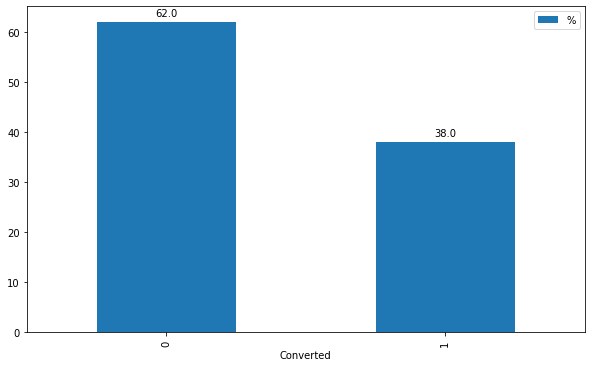

In [10615]:
# How is the distribution wrt the target variable?
df_converted = df[COLS_TARGET].groupby(by='Converted').agg({'Converted':'count'}).rename(columns={'Converted':'Count'})
df_converted.reset_index(inplace=True)
df_converted['%'] = df_converted['Count'].apply(lambda x: round(100 * x/df.shape[0]))
ax = df_converted.plot.bar(x='Converted', y='%', figsize=(10,6))
annotate(ax)
df_converted

- Target variable is a binary value - 0 or 1
- The data is not imbalanced.

### Summary
The missing values for the columns was handled as follows:
| Category | Column Name | Missing values? | Handling |
|---|---|---|---|
| LOC | Country | 27% | 27% values of Country is null and only 3% countries are outside india, If we impute India as missing values, then majority data would only be India and this column would add no significance to analysis. So keep the Missing values as a different category "UNKNOWN" |
| LOC | City |  |Many countries (Australia, Bahrain etc.) have City as "'Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai' which is incorrect. So we should DROP City. | 
|PROF| Occupation | 29% | Replace missing values as UNKNOWN.  |
|PROF| Reason | 29% | Around 29% rows have null Reason. We can impute the Reason with 'Better Career Prospects'. But then only .03% rows have Reason other than 'Better Career Prospects'. So the column Reason will add no significance to the model. So DROP the column Reason |
|PROF| Specialization | 15.6% | Replace missing values as UNKNOWN. |
|AD| Found | 70% | Group NaN as UNKNOWN |
|AD| AdXXX | - | - | Remove Column as almost all rows have the same value 'No' |
|AD| Recommendations | - | - | Remove Column as almost all rows have the same value 'No' |
|PREF| XXX |  - | Remove as almost all rows have the same value 'No' |
|PREF| NoEmail |  - | - |
|PREF| FreeCopy |  - | - |
|ACTIVITY| TotalVisits | 1.5% | - | Impute with median |
|ACTIVITY| PageViews | 1.5% | - | Impute with median |
|ACTIVITY| TimeSpent | -  | - | - |
|ACTIVITY| LastActivity |  1.1% | -  | Remove the rows with null values |
|ACTIVITY| LastNotableActivity | - | - | - |
|LEAD| LeadNumber | - | - |
|LEAD| LeadOrigin | - | - |
|LEAD| LeadSource | 0.4% | Remove the rows with null values |
|LEAD| LeadQuality | 51.6% | Replace missing values with UNKNOWN |
|LEAD| LeadProfile | 29.3% | LeadProfile has 74% of the values missing. Drop the column |
|LEAD| Tags | 36.3% | Drop tags column as including it gives a bad test accuracy and sensitivity |
|INDEXSCORE| ActivityIndex | 45.6%  | Almost half of the values are missing. Remove the column |
|INDEXSCORE| ProfileIndex | 45.6%  | Almost half of the values are missing. Remove the column |
|INDEXSCORE| ActivityScore | 45.6%  | Almost half of the values are missing. Remove the column |
|INDEXSCORE| ProfileScore | 45.6%  | Almost half of the values are missing. Remove the column |

### Bivariate Analysis

<AxesSubplot:>

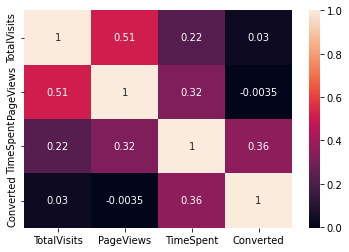

In [10616]:
sns.heatmap(df.corr(),annot=True)

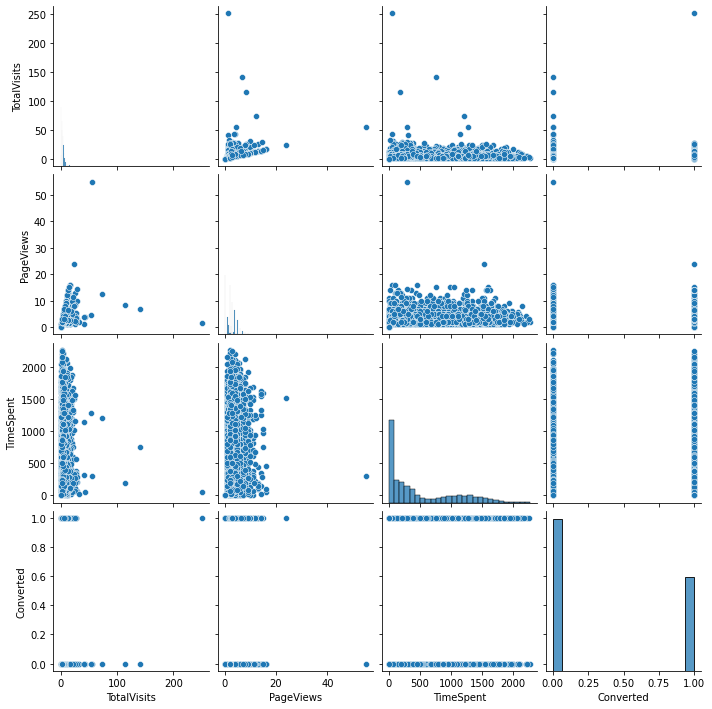

In [10617]:
sns.pairplot(data=df)

There is small correlation between TotalVisits and TimeSpent. Other variables are not correlated

## Build & evaluate Model

In [10618]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9137 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         9137 non-null   object 
 1   Occupation      9137 non-null   object 
 2   Specialization  9137 non-null   object 
 3   Found           9137 non-null   object 
 4   NoEmail         9137 non-null   object 
 5   FreeCopy        9137 non-null   object 
 6   TotalVisits     9137 non-null   float64
 7   PageViews       9137 non-null   float64
 8   TimeSpent       9137 non-null   int64  
 9   LastActivity    9137 non-null   object 
 10  LeadOrigin      9137 non-null   object 
 11  LeadSource      9137 non-null   object 
 12  LeadQuality     4395 non-null   object 
 13  Converted       9137 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.3+ MB


In [10619]:
print(df.shape, df.columns.tolist())

(9137, 14) ['Country', 'Occupation', 'Specialization', 'Found', 'NoEmail', 'FreeCopy', 'TotalVisits', 'PageViews', 'TimeSpent', 'LastActivity', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'Converted']


In [10620]:
# Group columns based on the type of data they hold and type of processing that is needed
COLS_YESNO =  ['FreeCopy', 'NoEmail']
COLS_DUMMIES = ['Country', 'Occupation', 'Specialization', 'Found', 'LastActivity', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'Tags']
COLS_NUMERIC = ['TotalVisits', 'PageViews', 'TimeSpent']

df_numeric = df[COLS_NUMERIC]
df_numeric

,TotalVisits,PageViews,TimeSpent
0,0.0,0.00,0
1,5.0,2.50,674
2,2.0,2.00,1532
3,1.0,1.00,305
4,2.0,1.00,1428
...,...,...,...
9235,8.0,2.67,1845
9236,2.0,2.00,238
9237,2.0,2.00,199
9238,3.0,3.00,499


#### Convert binary variables (Yes/No) to 0/1

In [10621]:
df[COLS_YESNO]

,FreeCopy,NoEmail
0,No,No
1,No,No
2,Yes,No
3,No,No
4,No,No
...,...,...
9235,No,Yes
9236,Yes,No
9237,Yes,Yes
9238,No,No


In [10622]:
# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
print("Before\n", df[COLS_YESNO].head())
df_yesno = df[COLS_YESNO].apply(binary_map)
print("After\n", df_yesno.head())

Before
   FreeCopy NoEmail
0       No      No
1       No      No
2      Yes      No
3       No      No
4       No      No
After
    FreeCopy  NoEmail
0         0        0
1         0        0
2         1        0
3         0        0
4         0        0


#### Create dummy features for categorical variables

In [10623]:
df_dummies = pd.DataFrame()
df_dummies = addDummies(df, 'Country', 'Country_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'Occupation', 'Occupation_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'Specialization', 'Specialization_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'Found', 'Found_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'LastActivity','LastActivity_Resubscribed to emails', df_dummies)
#df_dummies = addDummies(df, 'LastActivity', 'LastActivity_OTHERS', df_dummies)
df_dummies = addDummies(df, 'LeadOrigin', 'LeadOrigin_Quick Add Form', df_dummies)
df_dummies = addDummies(df, 'LeadSource', 'LeadSource_NC_EDM', df_dummies)
#df_dummies = addDummies(df, 'LeadSource', 'LeadSource_OTHERS', df_dummies)
df_dummies = addDummies(df, 'LeadQuality', 'LeadQuality_Low in Relevance', df_dummies)
#df_dummies = addDummies(df, 'Tags', 'Tags_UNKNOWN', df_dummies)

Before 0 After 38
Before 38 After 44
Before 44 After 62
Before 62 After 71
Before 71 After 87
Before 87 After 91
Before 91 After 111
Before 111 After 115


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [10624]:
print(df_dummies.info())
print(df_dummies.head())
df_target = df[COLS_TARGET]
print(df_target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9137 entries, 0 to 9239
Columns: 115 entries, Country_Asia/Pacific Region to LeadQuality_Worst
dtypes: uint8(115)
memory usage: 1.3 MB
None
   Country_Asia/Pacific Region  Country_Australia  Country_Bahrain  \
0                            0                  0                0   
1                            0                  0                0   
2                            0                  0                0   
3                            0                  0                0   
4                            0                  0                0   

   Country_Bangladesh  Country_Belgium  Country_Canada  Country_China  \
0                   0                0               0              0   
1                   0                0               0              0   
2                   0                0               0              0   
3                   0                0               0              0   
4                   0   

In [10625]:
# Add the results to the master dataframe
df = pd.concat([df_numeric, df_yesno, df_dummies], axis=1)
print(df.head())
print(df.info())
print(df.shape, df.isnull().sum().sum())

   TotalVisits  PageViews  TimeSpent  FreeCopy  NoEmail  \
0          0.0        0.0          0         0        0   
1          5.0        2.5        674         0        0   
2          2.0        2.0       1532         1        0   
3          1.0        1.0        305         0        0   
4          2.0        1.0       1428         0        0   

   Country_Asia/Pacific Region  Country_Australia  Country_Bahrain  \
0                            0                  0                0   
1                            0                  0                0   
2                            0                  0                0   
3                            0                  0                0   
4                            0                  0                0   

   Country_Bangladesh  Country_Belgium  ...  LeadSource_Welingak Website  \
0                   0                0  ...                            0   
1                   0                0  ...                            0

In [10626]:
print(len(df.columns.tolist()), df.columns.tolist())

120 ['TotalVisits', 'PageViews', 'TimeSpent', 'FreeCopy', 'NoEmail', 'Country_Asia/Pacific Region', 'Country_Australia', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Belgium', 'Country_Canada', 'Country_China', 'Country_Denmark', 'Country_France', 'Country_Germany', 'Country_Ghana', 'Country_Hong Kong', 'Country_India', 'Country_Indonesia', 'Country_Italy', 'Country_Kenya', 'Country_Kuwait', 'Country_Liberia', 'Country_Malaysia', 'Country_Netherlands', 'Country_Nigeria', 'Country_Oman', 'Country_Philippines', 'Country_Qatar', 'Country_Russia', 'Country_Saudi Arabia', 'Country_Singapore', 'Country_South Africa', 'Country_Sri Lanka', 'Country_Sweden', 'Country_Switzerland', 'Country_Tanzania', 'Country_Uganda', 'Country_United Arab Emirates', 'Country_United Kingdom', 'Country_United States', 'Country_Vietnam', 'Country_unknown', 'Occupation_Businessman', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'Sp

#### Create training & test datasets

In [10627]:
# Create X, y
X = df
y = df_target['Converted']

In [10628]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print(X_train.shape[0], X_test.shape[0])

6395 2742


In [10629]:
# Standardize the numerical variables
scaler = StandardScaler()
X_train[COLS_NUMERIC] = scaler.fit_transform(X_train[COLS_NUMERIC])
X_train.head()

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,TotalVisits,PageViews,TimeSpent,FreeCopy,NoEmail,Country_Asia/Pacific Region,Country_Australia,Country_Bahrain,Country_Bangladesh,Country_Belgium,...,LeadSource_Welingak Website,LeadSource_bing,LeadSource_blog,LeadSource_testone,LeadSource_welearnblog_Home,LeadSource_youtubechannel,LeadQuality_High in Relevance,LeadQuality_Might be,LeadQuality_Not Sure,LeadQuality_Worst
8701,-0.607948,-0.623541,0.211070,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6684,0.392522,1.198971,1.815810,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4406,-0.858065,-1.079169,-0.883322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2487,-0.858065,-1.079169,-0.883322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
561,-0.107713,0.287715,2.140074,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10630]:
# Check out the correlation among the variables.
#plt.figure(figsize = (20,10))
#sns.heatmap(X_train.corr(),annot = True)
#plt.show()

### Build the model

In [10631]:
# Build a Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  y * np.log(mu / (1 - mu + 1e-20)) +
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in multiply
  y * np.log(mu / (1 - mu + 1e-20)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6282
Model Family:                Binomial   Df Model:                          112
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 13 Oct 2021   Deviance:                   1.2222e+05
Time:                        09:07:19   Pearson chi2:                 5.98e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                             6.578e+15   7.92e+07   8.31e+07      0.000    6.58e+15    6.58e+15
TotalVisits                                       9.763e+13   1.16e+06   8.41e+07      0.000    9.76e+13    9.76e+13
PageViews                                        -1.139e+14   1.29e+06  -8.83e+07      0.000   -1.14e+14   -1.14e+14
TimeSpent                                          7.27e+14      1e+06   7.24e+08      0.000    7.27e+14    7.27e+14
FreeCopy                                          1.029e+13   3.31e+06   3.11e+06      0.000    1.03e+13    1.03e+13
NoEmail                                          -6.272e+14   4.47e+06   -1.4e+08      0.000   -6.27e+14   -6.27e+14
Country_Asia/Pacific Region                       9.954e+14    4.8e+07   2.07e+07      0.000    9.95e+14    9.95e+14
Country_Australia                                 -9.25e+14   2.64e+07  -3.51e+07      0.000   -9.25e+14   -9.25e+14
Country_Bahrain                                  -4.462e+14   3.43e+07   -1.3e+07      0.000   -4.46e+14   -4.46e+14
Country_Bangladesh                                1.472e+14   4.81e+07   3.06e+06      0.000    1.47e+14    1.47e+14
Country_Belgium                                   -4.18e+15   6.78e+07  -6.17e+07      0.000   -4.18e+15   -4.18e+15
Country_Canada                                    -4.62e+15    4.8e+07  -9.63e+07      0.000   -4.62e+15   -4.62e+15
Country_China                                    -2.972e+15   4.79e+07   -6.2e+07      0.000   -2.97e+15   -2.97e+15
Country_Denmark                                    -60.5317   5.17e-07  -1.17e+08      0.000     -60.532     -60.532
Country_France                                   -1.968e+15   4.84e+07  -4.07e+07      0.000   -1.97e+15   -1.97e+15
Country_Germany                                  -1.168e+15   3.94e+07  -2.96e+07      0.000   -1.17e+15   -1.17e+15
Country_Ghana                                    -3.391e+15   6.77e+07  -5.01e+07      0.000   -3.39e+15   -3.39e+15
Country_Hong Kong                                -4.343e+14   2.63e+07  -1.65e+07      0.000   -4.34e+14   -4.34e+14
Country_India                                    -3.125e+14   6.49e+06  -4.82e+07      0.000   -3.13e+14   -3.13e+14
Country_Indonesia                                -5.816e+15   6.78e+07  -8.58e+07      0.000   -5.82e+15   -5.82e+15
Country_Italy                                    -8.707e+15    4.8e+07  -1.81e+08      0.000   -8.71e+15   -8.71e+15
Country_Kenya                                    -2.893e+15   6.75e+07  -4.29e+07      0.000   -2.89e+15   -2.89e+15
Country_Kuwait                                   -4.147e+15   6.77e+07  -6.12e+07      0.000   -4.15e+15   -4.15e+15
Country_Liberia                          

There are too many features. Let's run RFE to retain only 15 features and remove the rest

In [10632]:
cols = runRFE(15, X_train, y_train )

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765

Columns selected by RFE: ['NoEmail', 'Country_Qatar', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'LastActivity_Olark Chat Conversation', 'LastActivity_SMS Sent', 'LeadOrigin_Lead Add Form', 'LeadOrigin_Lead Import', 'LeadSource_Welingak Website', 'LeadQuality_High in Relevance', 'LeadQuality_Not Sure', 'LeadQuality_Worst']
Columns dropped by RFE: ['LeadSource_testone', 'TimeSpent', 'LeadSource_Olark Chat', 'LeadSource_Live Chat', 'Country_Asia/Pacific Region', 'Country_Bangladesh', 'LeadSource_Google', 'Country_United States', 'Country_Ghana', 'Specialization_Human Resource Management', 'LeadSource_Referral Sites', 'Country_France', 'Found_SMS', 'Found_Other', 'Specialization_Finance Management', 'Country_Canada', 'Country_Bahrain', 'TotalVisits', 'LeadSource_Pay per Click Ads', 'Country_unknown', 'LeadSource_Facebook', 'Specialization_Operations Management', 'LastActivity_Email Link Clicked', 'LeadSourc

In [10633]:
# After RFE build the model
X_train = X_train[cols]
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6379
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.4
Date:                Wed, 13 Oct 2021   Deviance:                       5380.9
Time:                        09:07:28   Pearson chi2:                 6.40e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                                Features   VIF
5                  Occupation_Unemployed  2.03
9               LeadOrigin_Lead Add Form  1.50
8                  LastActivity_SMS Sent  1.45
13                  LeadQuality_Not Sure  1.31
11           LeadSource_Welingak Website  1.27
14                     LeadQuality_Worst  1.27
12         LeadQuality_High in Relevance  1.21
6        Occupation_Working Professional  1.16
4                     Occupation_Student  1.11
0                                NoEmail  1.07
7   LastActivity_Olark Chat Conversation  1.05
3                       Occupation_Other  1.01
10                LeadOrigin_Lead Import  1.01
1                          Country_Qatar  1.00
2                   Occupation_Housewife  1.00


In [10634]:
# 'Occupation_Housewife' has high p-value. Let us drop this variable
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Occupation_Housewife')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6380
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2703.1
Date:                Wed, 13 Oct 2021   Deviance:                       5406.3
Time:                        09:07:29   Pearson chi2:                 6.43e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10635]:
# 'Country_Qatar' has high p-value. Let us drop this variable
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Country_Qatar')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6381
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2706.5
Date:                Wed, 13 Oct 2021   Deviance:                       5413.0
Time:                        09:07:29   Pearson chi2:                 6.44e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10636]:
# LeadSource_Welingak Website' has high p-value. Let us drop this variable
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='LeadSource_Welingak Website')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6382
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2717.8
Date:                Wed, 13 Oct 2021   Deviance:                       5435.6
Time:                        09:07:29   Pearson chi2:                 6.78e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10637]:
# Columns that are in the model
print(X_train.columns.shape[0], X_train.columns)

12 Index(['NoEmail', 'Occupation_Other', 'Occupation_Student',
       'Occupation_Unemployed', 'Occupation_Working Professional',
       'LastActivity_Olark Chat Conversation', 'LastActivity_SMS Sent',
       'LeadOrigin_Lead Add Form', 'LeadOrigin_Lead Import',
       'LeadQuality_High in Relevance', 'LeadQuality_Not Sure',
       'LeadQuality_Worst'],
      dtype='object')


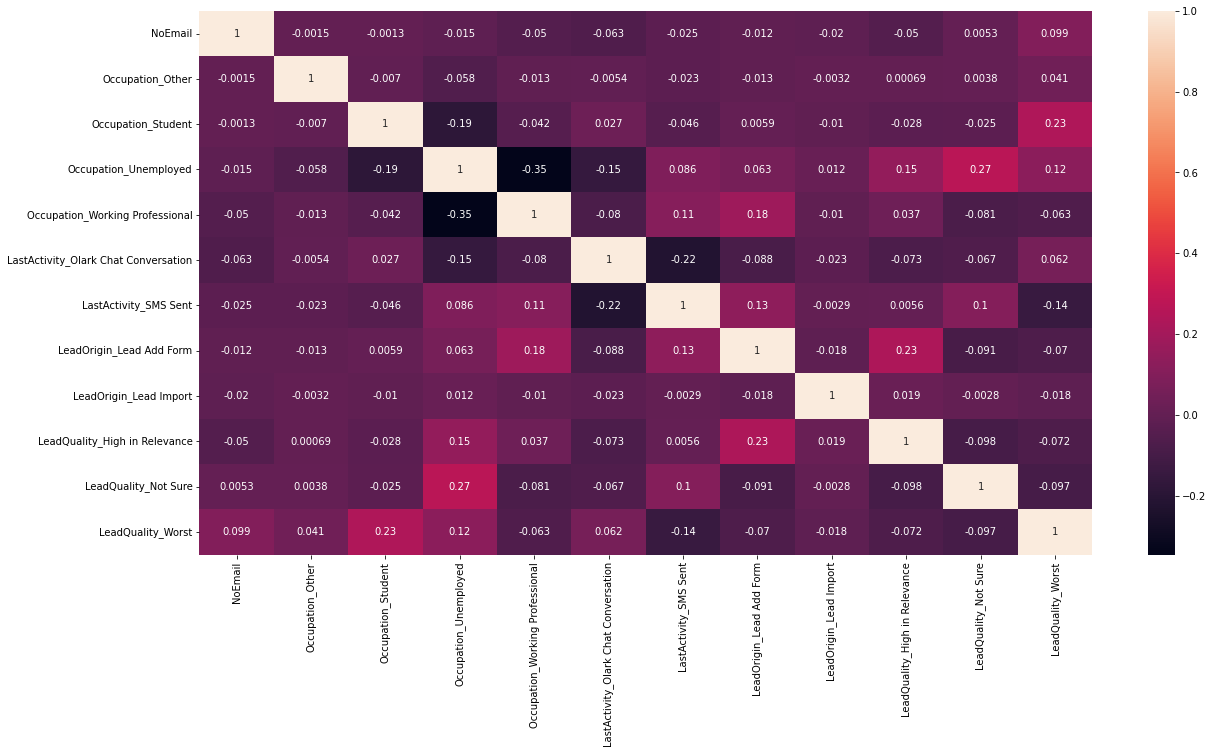

In [10638]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()

### Evaluate on the Training dataset

In [10639]:
y_train_pred_final = predict(lr_model, X_train_sm, y_train)

   Lead_Actual  Lead_Prob  Lead_ID  Lead_Predicted
0            1   0.116417     8701               0
1            0   0.376568     6684               0
2            1   0.949836     4406               1
3            1   0.707704     2487               1
4            0   0.376568      561               0


In [10640]:
confusionmatrix(y_train_pred_final, 'Lead_Actual', 'Lead_Predicted')

Confusion Matrix:
 [[3667  297]
 [ 959 1472]]
Accuracy: 80.36% Sensitivity: 60.55% Specificity: 92.51% FPR: 7.49% PPV: 83.21%


<Figure size 360x360 with 0 Axes>

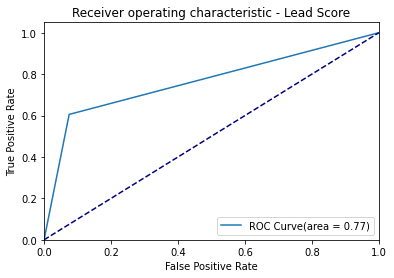

In [10641]:
fpr,tpr,thresholds = metrics.roc_curve(y_train_pred_final['Lead_Actual'],y_train_pred_final['Lead_Predicted'])
draw_roc(y_train_pred_final['Lead_Actual'],y_train_pred_final['Lead_Predicted'])

ROC curve area .77 is decent

In [10642]:
## Optimal cut off point
## Problem statement is to obtain lead conversion rate as 80%

# Predict for various cut-offs 
numbers = [float(x)/10 for x in range (10)]
for i in numbers:
    y_train_pred_final[i] = y_train_pred_final['Lead_Prob'].map(lambda x: 1 if x>i else 0)
y_train_pred_final

,Lead_Actual,Lead_Prob,Lead_ID,Lead_Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.116417,8701,0,1,1,0,0,0,0,0,0,0,0
1,0,0.376568,6684,0,1,1,1,1,0,0,0,0,0,0
2,1,0.949836,4406,1,1,1,1,1,1,1,1,1,1,1
3,1,0.707704,2487,1,1,1,1,1,1,1,1,1,0,0
4,0,0.376568,561,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,0,0.116417,366,0,1,1,0,0,0,0,0,0,0,0
6391,1,0.864320,82,1,1,1,1,1,1,1,1,1,1,0
6392,0,0.365482,8139,0,1,1,1,1,0,0,0,0,0,0
6393,0,0.033748,7028,0,1,0,0,0,0,0,0,0,0,0


In [10643]:
# Calculate accuracy, sensitivity & specificity for probab cut offs
cutoff_df = pd.DataFrame(columns=['prob','accuracy','sensi','speci'])

for i in numbers:
    cm1 = metrics.confusion_matrix(y_train_pred_final['Lead_Actual'],y_train_pred_final[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i,accuracy,sensi,speci]
print (cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.380141  1.000000  0.000000
0.1   0.1  0.534324  0.990539  0.254541
0.2   0.2  0.724472  0.900452  0.616549
0.3   0.3  0.726192  0.900041  0.619576
0.4   0.4  0.803909  0.606746  0.924823
0.5   0.5  0.803597  0.605512  0.925076
0.6   0.6  0.803440  0.603044  0.926337
0.7   0.7  0.802033  0.591937  0.930878
0.8   0.8  0.764816  0.408063  0.983602
0.9   0.9  0.727912  0.299054  0.990918


<Figure size 720x720 with 0 Axes>

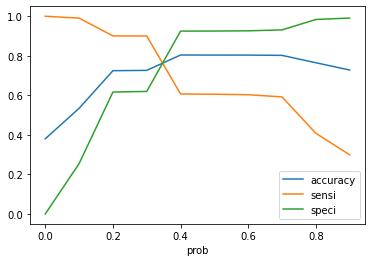

In [10644]:
# plot accuracy, sensitivity & specificity
plt.figure(figsize=(10,10))
cutoff_df.plot.line(x='prob',y=['accuracy','sensi','speci'])
plt.show()

From the plot, the optimal cut- off is 0.35

In [10645]:
OPTIMUM_CUTOFF = 0.35

In [10646]:
## New prdict the class for hte optinal cut-off
y_train_pred_final['Lead_Predicted_opt'] = y_train_pred_final['Lead_Prob'].map(lambda x:1 if x> OPTIMUM_CUTOFF else 0)
y_train_pred_final

,Lead_Actual,Lead_Prob,Lead_ID,Lead_Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Lead_Predicted_opt
0,1,0.116417,8701,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.376568,6684,0,1,1,1,1,0,0,0,0,0,0,1
2,1,0.949836,4406,1,1,1,1,1,1,1,1,1,1,1,1
3,1,0.707704,2487,1,1,1,1,1,1,1,1,1,0,0,1
4,0,0.376568,561,0,1,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,0,0.116417,366,0,1,1,0,0,0,0,0,0,0,0,0
6391,1,0.864320,82,1,1,1,1,1,1,1,1,1,1,0,1
6392,0,0.365482,8139,0,1,1,1,1,0,0,0,0,0,0,1
6393,0,0.033748,7028,0,1,0,0,0,0,0,0,0,0,0,0


In [10647]:
confusionmatrix(y_train_pred_final, 'Lead_Actual', 'Lead_Predicted_opt')

Confusion Matrix:
 [[2456 1508]
 [ 243 2188]]
Accuracy: 72.62% Sensitivity: 90.0% Specificity: 61.96% FPR: 38.04% PPV: 59.2%


The Accuracy is decent and Sensitivity is quite good. Let's proceed to evaluate on the test dataset

### Evaluate on the test dataset

In [10648]:
# Columns in the test dataset
print(len(X_test.columns.tolist()), X_test.columns.tolist())

120 ['TotalVisits', 'PageViews', 'TimeSpent', 'FreeCopy', 'NoEmail', 'Country_Asia/Pacific Region', 'Country_Australia', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Belgium', 'Country_Canada', 'Country_China', 'Country_Denmark', 'Country_France', 'Country_Germany', 'Country_Ghana', 'Country_Hong Kong', 'Country_India', 'Country_Indonesia', 'Country_Italy', 'Country_Kenya', 'Country_Kuwait', 'Country_Liberia', 'Country_Malaysia', 'Country_Netherlands', 'Country_Nigeria', 'Country_Oman', 'Country_Philippines', 'Country_Qatar', 'Country_Russia', 'Country_Saudi Arabia', 'Country_Singapore', 'Country_South Africa', 'Country_Sri Lanka', 'Country_Sweden', 'Country_Switzerland', 'Country_Tanzania', 'Country_Uganda', 'Country_United Arab Emirates', 'Country_United Kingdom', 'Country_United States', 'Country_Vietnam', 'Country_unknown', 'Occupation_Businessman', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'Sp

In [10649]:
## Scale the numerical data
X_test[COLS_NUMERIC] = scaler.transform(X_test[COLS_NUMERIC])
X_test.head()

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,TotalVisits,PageViews,TimeSpent,FreeCopy,NoEmail,Country_Asia/Pacific Region,Country_Australia,Country_Bahrain,Country_Bangladesh,Country_Belgium,...,LeadSource_Welingak Website,LeadSource_bing,LeadSource_blog,LeadSource_testone,LeadSource_welearnblog_Home,LeadSource_youtubechannel,LeadQuality_High in Relevance,LeadQuality_Might be,LeadQuality_Not Sure,LeadQuality_Worst
5080,-0.107713,0.287715,1.603933,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1893,1.142874,-0.167913,-0.594064,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5432,-0.858065,-1.079169,-0.883322,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3549,0.142405,0.743343,1.336783,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8231,0.392522,1.198971,-0.826208,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10650]:
# Get the list of columns in the model
print("All columns", len(cols), cols, "\n\nDropped columns", len(dropped_cols), dropped_cols)
cols = list(set(cols) - set(dropped_cols))
print("\nColumns in the model", len(cols), cols)

All columns 15 ['NoEmail', 'Country_Qatar', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'LastActivity_Olark Chat Conversation', 'LastActivity_SMS Sent', 'LeadOrigin_Lead Add Form', 'LeadOrigin_Lead Import', 'LeadSource_Welingak Website', 'LeadQuality_High in Relevance', 'LeadQuality_Not Sure', 'LeadQuality_Worst'] 

Dropped columns 108 ['LeadSource_testone', 'TimeSpent', 'LeadSource_Olark Chat', 'LeadSource_Live Chat', 'Country_Asia/Pacific Region', 'Country_Bangladesh', 'LeadSource_Google', 'Country_United States', 'Country_Ghana', 'Specialization_Human Resource Management', 'LeadSource_Referral Sites', 'Country_France', 'Found_SMS', 'Found_Other', 'Specialization_Finance Management', 'Country_Canada', 'Country_Bahrain', 'TotalVisits', 'LeadSource_Pay per Click Ads', 'Country_unknown', 'LeadSource_Facebook', 'Specialization_Operations Management', 'LastActivity_Email Link Clicked', 'LeadSource_youtubecha

In [10651]:
X_test = X_test[cols]
X_test.head()

,LeadQuality_Worst,Occupation_Working Professional,LastActivity_Olark Chat Conversation,Occupation_Unemployed,LeadOrigin_Lead Import,LeadQuality_High in Relevance,LeadOrigin_Lead Add Form,LastActivity_SMS Sent,Occupation_Other,Occupation_Student,NoEmail,LeadQuality_Not Sure
5080,0,0,0,1,0,0,0,0,0,0,0,0
1893,0,0,0,0,0,0,0,0,0,0,0,0
5432,0,0,0,0,0,0,0,1,0,0,1,0
3549,0,1,0,0,0,0,0,1,0,0,0,0
8231,0,0,0,1,0,0,0,1,0,0,0,0


In [10652]:
# predict the probabilities
X_test_sm = sm.add_constant(X_test)
print(len(X_test_sm.columns.tolist()), X_test_sm.columns.tolist())
y_test_pred_final =  predict(lr_model, X_test_sm, y_test)

13 ['const', 'LeadQuality_Worst', 'Occupation_Working Professional', 'LastActivity_Olark Chat Conversation', 'Occupation_Unemployed', 'LeadOrigin_Lead Import', 'LeadQuality_High in Relevance', 'LeadOrigin_Lead Add Form', 'LastActivity_SMS Sent', 'Occupation_Other', 'Occupation_Student', 'NoEmail', 'LeadQuality_Not Sure']
   Lead_Actual  Lead_Prob  Lead_ID  Lead_Predicted
0            1   0.365482     5080               0
1            0   0.116417     1893               0
2            1   0.204490     5432               0
3            1   0.969864     3549               1
4            0   0.818332     8231               1


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10653]:
## New prdicted variable column
y_test_pred_final['Lead_Predicted_opt'] = y_test_pred_final['Lead_Prob'].map(lambda x:1 if x > OPTIMUM_CUTOFF else 0)
y_test_pred_final

,Lead_Actual,Lead_Prob,Lead_ID,Lead_Predicted,Lead_Predicted_opt
0,1,0.365482,5080,0,1
1,0,0.116417,1893,0,0
2,1,0.204490,5432,0,0
3,1,0.969864,3549,1,1
4,0,0.818332,8231,1,1
...,...,...,...,...,...
2737,0,0.132463,579,0,0
2738,0,0.365482,968,0,1
2739,1,0.818332,4477,1,1
2740,1,0.365482,4528,0,1


In [10654]:
confusionmatrix(y_test_pred_final, 'Lead_Actual', 'Lead_Predicted_opt')

Confusion Matrix:
 [[838 855]
 [208 841]]
Accuracy: 61.23% Sensitivity: 80.17% Specificity: 49.5% FPR: 50.5% PPV: 49.59%


The model has performed well on the test data set as well with a decent roc area, accuracy and good sensitivity. So we could use this as our final model. Let's look at the interpretation of the model

### Interpretation of the model
|	variable	|	co-efficient	|	Interpretation	|
|	---	|	---	|	---	|
|	Occupation_Working Professional 	|	3.8785	|	Working Professionals are more likely to convert to paid users	|
|	Occupation_Other	|	3.4415	|	Customers with occupation Other are more likely to convert to paid users	|
|	LeadQuality_High in Relevance 	|	2.8699	|	Leads marked with High Relevance are more likely to convert to paid users	|
|	Occupation_Student	|	2.4677	|	Students are likely to convert to paid users	|
|	LeadOrigin_Lead Add Form 	|	2.0567	|	Leads from filling a form are likely to convert to paid users	|
|	Occupation_Unemployed	|	1.4752	|	Unemployed customers are likely to convert to paid users	|
|	LastActivity_SMS Sent	|	1.4359	|	In cases where SMS was sent, customers are likely to convert to paid users	|
|	LastActivity_Unsubscribed	|	1.3751	|	In cases where the notifications were unsubscribed, customers are likely to convert to paid users	|
|	LastActivity_Olark Chat Conversation	|	-0.9261	|	-	|
|	LeadOrigin_Lead Import 	|	-1.0383	|	-	|
|	LeadQuality_Not Sure 	|	-1.3884	|	Leads that are marked as Not sure are less likely to convert to paid users	|
|	NoEmail	|	-1.3517	|	Customers who have marked Do Not Email as Yes are less likely to convert to paid users OR Customers who have marked Do Not Email as No are more likely to convert to paid users	|
|	const	|	-2.0268	|	-	|
|	LeadQuality_Worst	|	-3.7954	|	Leads marked as Worst quality are least likely to convert to paid users	|

### Calculate the client scores
Calculate the client score = Lead probability X 100

In [10655]:

# Concatenate the training and test predictions and add a new column to add the client score as a percentage
print(f"Before concatenation: Train: {y_train_pred_final.shape[0]} Test: {y_test_pred_final.shape[0]} Total: {y_train_pred_final.shape[0] + y_test_pred_final.shape[0]} ")
y_pred_final = pd.concat([y_train_pred_final,y_test_pred_final], axis=0)
y_pred_final = y_pred_final.rename(columns={'Lead_Prob':'Client_Score'})
y_pred_final['Client_Score'] = round(y_pred_final['Client_Score']*100,2)
print(f"After concatenation: Total: {y_pred_final.shape[0]}")
y_pred_final

Before concatenation: Train: 6395 Test: 2742 Total: 9137 
After concatenation: Total: 9137


,Lead_Actual,Client_Score,Lead_ID,Lead_Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Lead_Predicted_opt
0,1,11.64,8701,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,37.66,6684,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,94.98,4406,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,70.77,2487,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
4,0,37.66,561,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,0,13.25,579,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2738,0,36.55,968,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2739,1,81.83,4477,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2740,1,36.55,4528,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [10656]:
# Final output - Lead Id and the Client Score

client_score = y_pred_final[['Lead_ID', 'Client_Score']]
client_score

,Lead_ID,Client_Score
0,8701,11.64
1,6684,37.66
2,4406,94.98
3,2487,70.77
4,561,37.66
...,...,...
2737,579,13.25
2738,968,36.55
2739,4477,81.83
2740,4528,36.55
